- I didn't know much about the field of horse racing, so I explored the data by searching for information on the Internet.
- It's hard to say that there's a clear conclusion, but I hope you enjoy it.
- Distance and speed units were used in kilometers.
- There may be awkward parts in English because I used a translator after organizing them in Korean.

- 경마 분야는 잘 알지 못해 이것저것 정보를 인터넷에서 찾아보며 데이터를 탐험했습니다.
- 뚜렷한 결론이 있다고 말하긴 힘든 노트북이지만, 재밌게 보셨으면 합니다.
- 거리, 속도 단위는 km 단위를 사용했습니다.
- 한글로 정리해둔 뒤 번역기를 썼기 때문에 영문법상 어색한 부분이 있을 수 있습니다.

In [1]:
# !pip install --upgrade seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import seaborn.objects as so

import scipy.stats as stats

from haversine import haversine

In [2]:
def preprocess_race():

    race_df = pd.read_csv('../input/big-data-derby-2022/nyra_race_table.csv')

    race_df['race_id'] = race_df[['track_id', 'race_date', 'race_number']].astype('str').agg('_'.join, axis = 1)
    race_df.insert(0, 'race_id', race_df.pop('race_id'))
    
    
    race_df['distance_feet'] = race_df['distance_id'].apply(lambda x : int(6.6 * x)) # to_feet
    race_df['distance_km'] = race_df['distance_feet'].apply(lambda x : x / 3281)

    race_df['race_date'] = pd.to_datetime(race_df['race_date'])
    
    race_df['track_condition'] = race_df['track_condition'].str.replace(" ", "")

    # Dirt Condition Separate 
    race_df.loc[race_df['course_type'] == 'D', 'dirt_condition'] = race_df['track_condition']
    dirt_condition_order = pd.CategoricalDtype(['FT', 'GD', 'MY', 'SY'], ordered = True)
    race_df['dirt_condition'] = race_df['dirt_condition'].astype(dirt_condition_order)
    
    # Turf Condition Separate
    race_df.loc[race_df['course_type'].isin(['I', 'O', 'T']), 'turf_condition'] = race_df['track_condition']
    turf_condition_order = pd.CategoricalDtype(['FM', 'GD', 'YL', 'SF'], ordered = True)
    race_df['turf_condition'] = race_df['turf_condition'].astype(turf_condition_order)
    
    race_df.drop(['purse', 'post_time', 'track_condition'], axis = 1, inplace = True)
    
    # drop hurdle race
    race_df.drop(race_df[race_df['course_type'] == 'M'].index, inplace = True)
    
    return race_df

def preprocess_start():
    start_df = pd.read_csv('../input/big-data-derby-2022/nyra_start_table.csv', 
                        names = ['track_id', 'race_date', 'race_number', 'program_number', 'weight_carried', 'jockey', 'odds', 'position_at_finish'])
    
    start_df['race_date'] = pd.to_datetime(start_df['race_date'])
    start_df['race_id'] = start_df[['track_id', 'race_date', 'race_number']].astype('str').agg('_'.join, axis = 1)

    start_df['program_number'] = start_df['program_number'].str.replace(" ", "")
    return start_df

def preprocess_track():
    track_df = pd.read_csv('../input/big-data-derby-2022/nyra_tracking_table.csv')
    
    track_df['race_date'] = pd.to_datetime(track_df['race_date'])
#     track_df['distance_feet'] = track_df['distance_id'].apply(lambda x : int(6.6 * x))
    track_df['race_id'] = track_df[['track_id', 'race_date', 'race_number']].astype('str').agg('_'.join, axis = 1)

    track_df['program_number'] = track_df['program_number'].str.replace(" ", "")

    return track_df

def preprocess_2022_derby():
    race_df = preprocess_race()
    start_df = preprocess_start()
    track_df = preprocess_track()
    return race_df, start_df, track_df

In [3]:
race_df, start_df, track_df = preprocess_2022_derby()

# 1. Seasons and Tracks

### Summary
1. Each season consists of Spring (3, 4, 5), Summer (6, 7, 8), Autumn (9, 10, 11), and Winter (12, 1, 2)
2. `Dirt` competition is more than `Turf` competition:
    1. Total number of matches - $Dirt : Turf = 2 : 1$
    2. In terms of seasons, 'Dirt' always has around 300 games, while 'Turf' has a significant decrease in the number of games in spring and winter
    3. About `Dirt`: The condition of the ground often deteriorates in spring and winter, while it is good to run in summer and autumn

### 요약
1. 각 계절은 Spring(3, 4, 5), Summer(6, 7, 8), Autumn(9, 10, 11), Winter(12, 1, 2)로 구성
2. `Dirt` 경기가 `Turf` 경기보다 많음 :
    1. 전체 경기수 - $Dirt : Turf = 2 : 1$
    2. 계절로 놓고 봤을 때, `Dirt`는 항상 300경기 내외의 경기 수가 있는 반면 `Turf`는 봄, 겨울에 경기 수가 확연히 감소함
    3. `Dirt`에 관해 : 봄, 겨울에는 땅의 상태가 달리기 나빠지는 경우가 많고 반면 여름, 가을에는 달리기 좋은 상태
    

- 트랙 컨디션 [위키](https://en.wikipedia.org/wiki/Going_(horse_racing))
    - `Dirt` 
        - `FT : Fast` : 건조하고 균일하며 탄력 있는 표면
        - `GD : Good` : `FT`보다는 느린 듯
        - `MY : Muddy` : 젖었음, 고인 물은 없음
        - `SY : Sloppy` : 고인 물이 보일 정도로 물로 포화된 트랙
    - `Turf`
        - `FM : Firm` : 단단하고 탄력 있는 표면
        - `GD : Good` : `FM`보다 약간 부드러운 잔디 코스
        - `YL : Yielding` : 최근 비가 와서 지면에 상당한 양의 `give(탄성)`가 있음
        - `SF : Soft` : 수분이 많음. 말이 깊게 가라앉을 수 있음

In [4]:
# 1. Seasons and track conditions
race_df['month'] = race_df['race_date'].dt.month

race_df.loc[race_df['month'].isin([3, 4, 5]), 'season'] = 'spring'
race_df.loc[race_df['month'].isin([6, 7, 8]), 'season'] = 'summer'
race_df.loc[race_df['month'].isin([9, 10, 11]), 'season'] = 'autumn'
race_df.loc[race_df['month'].isin([12, 1, 2]), 'season'] = 'winter'

season_order = pd.CategoricalDtype(['spring', 'summer', 'autumn', 'winter'],
                                        ordered = True)
race_df['season'] = race_df['season'].astype(season_order)

race_df

,race_id,track_id,race_date,race_number,distance_id,course_type,run_up_distance,race_type,distance_feet,distance_km,dirt_condition,turf_condition,month,season
0,AQU_2019-01-01_1,AQU,2019-01-01,1,650,D,36,AOC,4290,1.307528,MY,NaN,1,winter
1,AQU_2019-01-01_2,AQU,2019-01-01,2,600,D,48,MCL,3960,1.206949,MY,NaN,1,winter
2,AQU_2019-01-01_3,AQU,2019-01-01,3,550,D,54,MCL,3630,1.106370,MY,NaN,1,winter
3,AQU_2019-01-01_4,AQU,2019-01-01,4,900,D,101,AOC,5940,1.810424,MY,NaN,1,winter
4,AQU_2019-01-01_5,AQU,2019-01-01,5,700,D,60,ALW,4620,1.408107,MY,NaN,1,winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,SAR_2019-09-02_7,SAR,2019-09-02,7,900,D,79,CLM,5940,1.810424,SY,NaN,9,autumn
1996,SAR_2019-09-02_8,SAR,2019-09-02,8,700,D,32,AOC,4620,1.408107,SY,NaN,9,autumn
1997,SAR_2019-09-02_9,SAR,2019-09-02,9,850,I,22,STK,5610,1.709845,NaN,SF,9,autumn
1998,SAR_2019-09-02_10,SAR,2019-09-02,10,700,D,32,STK,4620,1.408107,SY,NaN,9,autumn


In [5]:
dirt_color = ['#783f04', '#bb8632', '#cca466', '#ddc299']
dirt_palette = sns.color_palette(dirt_color, as_cmap = True)

turf_color = ['#38761d', '#739f60', '#afc8a4', '#ebf1e8']
turf_palette = sns.color_palette(turf_color, as_cmap = True)

dirt_turf_color = ['#783f04', '#38761d']
dt_palette = sns.color_palette(dirt_turf_color, as_cmap = True)


In [6]:
temp_df = race_df.groupby('course_type')['race_id'].count().to_frame().reset_index().rename(columns = {'race_id' : 'races'})
temp_df.loc[temp_df['course_type'] == 'T', 'races'] = temp_df.loc[1:, 'races'].sum()
temp_df.drop(temp_df[temp_df['course_type'].isin(['I', 'O'])].index, inplace = True)

<Figure size 720x360 with 0 Axes>

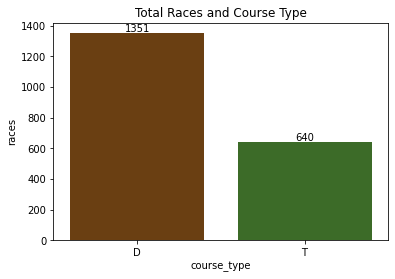

<Figure size 720x360 with 0 Axes>

In [7]:
ax = sns.barplot(data = temp_df, x = 'course_type', y = 'races', palette = ['#783f04', '#38761d'])
ax.bar_label(ax.containers[0])
plt.title('Total Races and Course Type')
plt.figure(figsize = (10, 5))

In [8]:
temp_df = race_df.copy()
temp_df.loc[temp_df['course_type'].isin(['I', 'O']), 'course_type'] = 'T'
temp_df = temp_df.groupby(['season', 'course_type'])['race_id'].count().to_frame().reset_index().rename(columns = {'race_id' : 'races'})
# temp_df.drop(temp_df[temp_df['course_type'].isin(['I', 'O'])].index, inplace = True)

<Figure size 720x360 with 0 Axes>

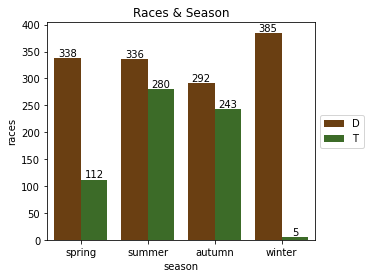

<Figure size 720x360 with 0 Axes>

In [9]:
ax = sns.barplot(data = temp_df, x = 'season', y = 'races', hue = 'course_type', palette = ['#783f04', '#38761d'])

ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

plt.title('Races & Season')
plt.figure(figsize = (10, 5))

In [10]:
sub_dirt_df = (race_df.groupby(['season', 'dirt_condition'])['race_id'].count()
                                                                      .to_frame()
                                                                      .reset_index()
                                                                      .rename(columns = {"race_id" : 'counts'})
              )
sub_dirt_df['season_counts'] = sub_dirt_df.groupby('season')['counts'].transform('sum')
sub_dirt_df['seasonal_condition_rate'] = sub_dirt_df.apply(lambda x : round((x['counts'] / x ['season_counts']), 2), axis = 1)
sub_dirt_df = sub_dirt_df[sub_dirt_df['counts'] != 0]

sub_turf_df = race_df.copy()
sub_turf_df.loc[sub_turf_df['course_type'].isin(['I', 'O']), 'course_type'] = 'T'
sub_turf_df = (race_df.groupby(['season', 'turf_condition'])['race_id'].count()
                                                                       .to_frame()
                                                                       .reset_index()
                                                                       .rename(columns = {"race_id" : 'counts'})
              )
sub_turf_df = sub_turf_df[sub_turf_df['counts'] != 0]

In [11]:
sub_dirt_df.head(2)

,season,dirt_condition,counts,season_counts,seasonal_condition_rate
0,spring,FT,244,338,0.72
1,spring,GD,18,338,0.05


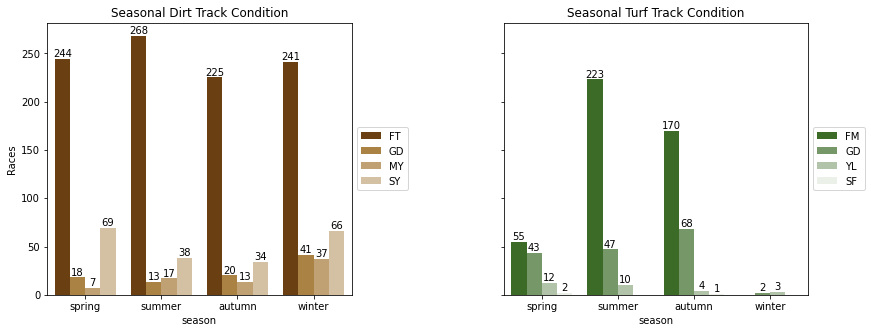

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)


sns.barplot(data = sub_dirt_df,
              x = 'season',
              y = 'counts',
             hue = 'dirt_condition',
             ax = ax[0],
             palette = dirt_palette
           )

ax[0].set_title('Seasonal Dirt Track Condition')
ax[0].set_ylabel('Races')
ax[0].legend().set_visible(False)
box = ax[0].get_position()
ax[0].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[0].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))



sns.barplot(data = sub_turf_df,
              x = 'season',
              y = 'counts',
             hue = 'turf_condition',
             ax = ax[1],
           palette = turf_palette
           )

ax[1].set_title('Seasonal Turf Track Condition')
ax[1].set_ylabel(None)

# legend
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax[1].legend(loc = 'center left', bbox_to_anchor=(1, 0.5))

for i in range(2):
    for j in range(4):
        ax[i].bar_label(ax[i].containers[j])

Text(0.5, 1.0, 'Seasonal Dirt Condition Rate : FT vs SY')

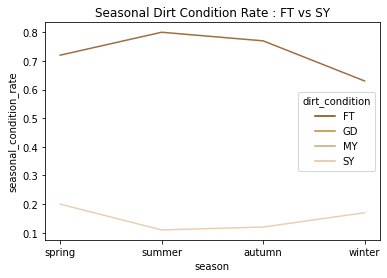

In [13]:
sns.lineplot(data = (sub_dirt_df
                     [sub_dirt_df['dirt_condition'].isin(['FT', 'SY'])][:]
                    ), 
            x = 'season', 
            y = 'seasonal_condition_rate', 
            hue = 'dirt_condition',
            palette = dirt_palette,
            alpha = 0.75)
# plt.gca().legend().set_visible(False)

plt.title('Seasonal Dirt Condition Rate : FT vs SY')

$SeasonalDirt(Turf)Condition Rate = \frac{Dirt Condition Races}{Total Dirt(Turf) Races}$

# 2. Jockey

In [14]:
merged_df = start_df.merge(race_df,
                on = ['race_id'])
# merged_df.insert(0, 'race_id', merged_df.pop('race_id'))
merged_df.head(2)

,track_id_x,race_date_x,race_number_x,program_number,weight_carried,jockey,odds,position_at_finish,race_id,track_id_y,...,distance_id,course_type,run_up_distance,race_type,distance_feet,distance_km,dirt_condition,turf_condition,month,season
0,AQU,2019-01-01,1,1,123,Dylan Davis,130,2,AQU_2019-01-01_1,AQU,...,650,D,36,AOC,4290,1.307528,MY,NaN,1,winter
1,AQU,2019-01-01,1,2,120,Junior Alvarado,295,3,AQU_2019-01-01_1,AQU,...,650,D,36,AOC,4290,1.307528,MY,NaN,1,winter


## Jockeys, number of competitions, average ranking, average ranking per course type
### Summary : Use all data

1. The null hypothesis is that "the number of games and the order of participation have no relationship," and the results differ depending on how the data is prepared.
    1. ***Excluding the range exceeding 'IQR'**: Regarding the number of matches and the average ranking, **There is little correlation + the p-value value is also large**
    2. **Full data**: **The correlation coefficient is high + the p-value is also a value that can reject the null hypothesis.**
2. When each of the riders is placed on the scatterplot, the ranking of the riders is integrated into the mean for the number of participants, and then the correlation coefficient and p-value value are different.

- What can be said to be right?
    - There are a total of 162 players, and 29 players have played more than "Upper IQR Boundary: 82 games," accounting for about 17%. I don't think it's a negligible figure.

1. 귀무가설은 "경기 수와 출전 순위는 아무런 관계가 없다"이고, 데이터를 어떻게 준비하느냐에 따라 다른 결과가 나왔음.
    1. **`IQR`을 넘는 범위 제외** : 경기수와 평균 순위에 관해, **상관관계가 거의 없음 + p-value 값도 크게 나옴**
    2. **전체 데이터** : **상관계수가 높게 나옴 + p-value도 귀무가설을 기각할 수 있는 수치가 나옴**
2. 기수 각각을 산점도에 놨을 때 순위와, 출전수에 대해 기수들의 순위를 평균으로 통합한 다음 산점도에 놨을 때, 상관계수와 p-value값은 다르게 나옴

- 무엇이 맞다고 할 수 있을까?
    - 총 162명인데 `Upper IQR Boundary : 82경기` 이상 뛴 기수가 29명으로 약 17%를 차지한다. 무시할만한 수치는 아니라고 생각됨.

### Find Outliers

In [15]:
jockey_df = merged_df.loc[:, ['race_id', 'jockey', 'course_type', 'dirt_condition', 'turf_condition', 'position_at_finish']]
jockey_df['num_of_competitions'] = jockey_df.groupby('jockey')['race_id'].transform('count')
jockey_df['avg_rank_by_jockey']= jockey_df.groupby(['jockey'])['position_at_finish'].transform('mean')
jockey_app_rank = jockey_df[['jockey', 'num_of_competitions', 'avg_rank_by_jockey']].drop_duplicates()
jockey_app_rank['jockey'].count()
jockey_app_rank.describe()

,num_of_competitions,avg_rank_by_jockey
count,162.000000,162.000000
mean,91.617284,5.224499
std,224.444328,1.800853
min,1.000000,1.000000
25%,1.250000,4.206631
50%,4.000000,5.013761
75%,33.500000,6.030612
max,1274.000000,13.000000


Text(0.5, 1.0, 'num_of_competitions Data Except Outliers')

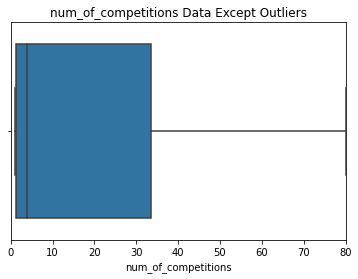

In [16]:
sns.boxplot(data = jockey_app_rank, x = 'num_of_competitions')

plt.xlim([0, 80])
plt.title("num_of_competitions Data Except Outliers")

In [17]:
# upper_boundary
x = jockey_app_rank['num_of_competitions']
q_75, q_25 = np.percentile(x, [75, 25])

iqr = q_75 - q_25
up_boundary = q_75 + 1.5 * iqr
up_boundary

81.875

In [18]:
jockey_app_rank[jockey_app_rank['num_of_competitions'] >= up_boundary]['jockey'].count()

29

#### 1. num_of_competitions : Exclude outlier data beyond IQR

In [19]:
jockey_app_rank_inner = jockey_app_rank[jockey_app_rank['num_of_competitions'] <= up_boundary][:]
jockey_app_rank_inner

,jockey,num_of_competitions,avg_rank_by_jockey
3,Jomar Garcia,2,5.000000
41,Frankie Pennington,4,4.750000
57,Joel Sone,17,5.882353
74,Julio Correa,68,5.029412
85,Pablo Fragoso,40,6.325000
...,...,...,...
13691,Jose Angel Garcia,1,7.000000
13847,Jose Antonio Gallego,4,7.500000
13866,Sophie Doyle,1,3.000000
14247,Martin Chuan,1,12.000000


corcoef = 0.03427458421381542, p-value = 0.6953111045100181


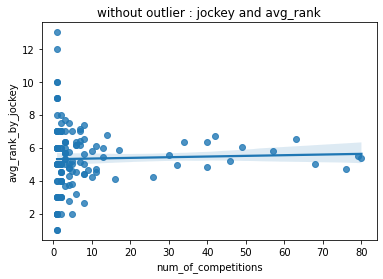

In [20]:
sns.regplot(data = jockey_app_rank_inner, x = 'num_of_competitions', y = 'avg_rank_by_jockey')
plt.title("without outlier : jockey and avg_rank")
r, p_value = stats.pearsonr(x = jockey_app_rank_inner['num_of_competitions'], y = jockey_app_rank_inner['avg_rank_by_jockey'])
print(f"corcoef = {r}, p-value = {p_value}")

corcoef = 0.14844805110940265, p-value = 0.4421747777483574


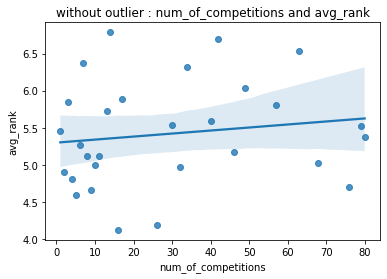

In [21]:

temp_df = jockey_app_rank_inner.groupby('num_of_competitions')['avg_rank_by_jockey'].mean().to_frame().reset_index().rename(columns = {'avg_rank_by_jockey' : 'avg_rank'})
sns.regplot(data = temp_df, x = 'num_of_competitions', y = 'avg_rank')
plt.title('without outlier : num_of_competitions and avg_rank')
r, p_value =stats.pearsonr(x = temp_df['num_of_competitions'], y = temp_df['avg_rank'])
print(f"corcoef = {r}, p-value = {p_value}")

#### 2. Plot without removing outlier data
- The total number of jockeys is 162, and the value of 'nunique()' is 58.

(-0.16868297382516895, 0.03189222439937974)

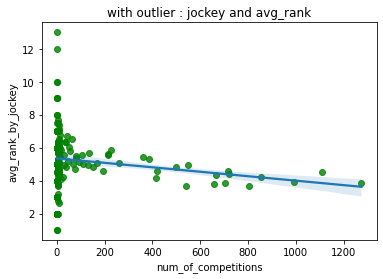

In [22]:
sns.regplot(data = jockey_app_rank,
               x = 'num_of_competitions',
               y = 'avg_rank_by_jockey',
#                ci = None,
               scatter_kws = {'color' : 'green'})

plt.title("with outlier : jockey and avg_rank")
stats.pearsonr(x = jockey_app_rank['num_of_competitions'], y = jockey_app_rank['avg_rank_by_jockey'])

In [23]:
dirt_appear_df = (jockey_df[jockey_df['course_type'] == 'D'].groupby('jockey')['race_id'].count()
                                                                                         .to_frame()
                                                                                         .reset_index()
                                                                                         .rename(columns = {'race_id' : 'dirt_num_of_competitions'}))
turf_appear_df = (jockey_df[jockey_df['course_type'].isin(['T', 'I', 'O'])].groupby('jockey')['race_id'].count()
                                                                                                     .to_frame()
                                                                                                     .reset_index()
                                                                                                     .rename(columns = {'race_id' : 'turf_num_of_competitions'}))

jockey_df = (jockey_df.merge(dirt_appear_df, how = 'left', on = 'jockey')
                      .merge(turf_appear_df, how = 'left', on = 'jockey'))
jockey_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 14842 entries, 0 to 14841
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race_id                   14842 non-null  object  
 1   jockey                    14842 non-null  object  
 2   course_type               14842 non-null  object  
 3   dirt_condition            9467 non-null   category
 4   turf_condition            5375 non-null   category
 5   position_at_finish        14842 non-null  int64   
 6   num_of_competitions       14842 non-null  int64   
 7   avg_rank_by_jockey        14842 non-null  float64 
 8   dirt_num_of_competitions  14795 non-null  float64 
 9   turf_num_of_competitions  14680 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 1.0+ MB


In [24]:
jockey_df['dirt_num_of_competitions'].fillna(0, inplace = True)
jockey_df['turf_num_of_competitions'].fillna(0, inplace = True)

jockey_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14842 entries, 0 to 14841
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race_id                   14842 non-null  object  
 1   jockey                    14842 non-null  object  
 2   course_type               14842 non-null  object  
 3   dirt_condition            9467 non-null   category
 4   turf_condition            5375 non-null   category
 5   position_at_finish        14842 non-null  int64   
 6   num_of_competitions       14842 non-null  int64   
 7   avg_rank_by_jockey        14842 non-null  float64 
 8   dirt_num_of_competitions  14842 non-null  float64 
 9   turf_num_of_competitions  14842 non-null  float64 
dtypes: category(2), float64(3), int64(2), object(3)
memory usage: 1.0+ MB


In [25]:
# 1. 출전 수와 평균 순위
jockey_df['num_of_competitions'] = jockey_df.groupby('jockey')['race_id'].transform('nunique')
app_rank = (jockey_df.groupby('num_of_competitions')['position_at_finish'].mean()
                                                                 .to_frame()
                                                                 .reset_index()
                                                                 .rename(columns = {'position_at_finish' : 'avg_rank'}))

# 2. Dirt 출전 수와 평균 순위
dirt_app_rank = (jockey_df[jockey_df['course_type'] == 'D'].groupby('dirt_num_of_competitions')['position_at_finish']
                                                           .mean()
                                                           .to_frame()
                                                           .reset_index()
                                                           .rename(columns = {'position_at_finish' : 'dirt_avg_rank'}))

turf_app_rank = (jockey_df[jockey_df['course_type'].isin(['T', 'I', 'O'])].groupby('turf_num_of_competitions')['position_at_finish']
                                                                           .mean()
                                                                           .to_frame()
                                                                           .reset_index()
                                                                           .rename(columns = {'position_at_finish' : 'turf_avg_rank'}))

corrcoef : -0.631658005069876, p-value : 1.0554257650012832e-07


Text(0.5, 1.0, 'Total num_of_competitions and Average Rank')

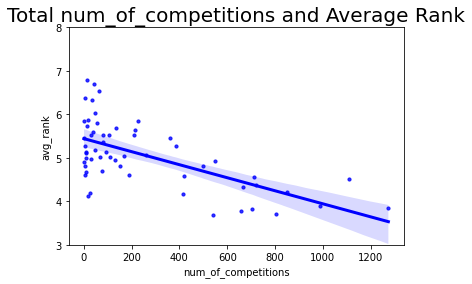

In [26]:
def get_regplot(df, col1_name, col2_name, color = 'blue'):
    sns.regplot(data = df,
                x = col1_name,
                y = col2_name,
#                 ci = None,
                color = color,
                line_kws = {
#                             'color' : 'grey',
                            'lw' : 3
                },
                scatter_kws = {'s' : 10,
#                               'color' : 'grey'
                              })
    
    plt.ylim([3, 8])

def get_pearsonr(col1, col2):
    corrcoef, p_value = stats.pearsonr(x = col1,
                                       y = col2)
    print(f"corrcoef : {corrcoef}, p-value : {p_value}")
    
get_regplot(app_rank, 'num_of_competitions', 'avg_rank')
get_pearsonr(app_rank['num_of_competitions'], app_rank['avg_rank'])
plt.title("Total num_of_competitions and Average Rank", fontsize = 20)

corrcoef : -0.6305955921051908, p-value : 5.43089806006367e-07


Text(0.5, 1.0, 'Dirt : num_of_competitions and Average Rank')

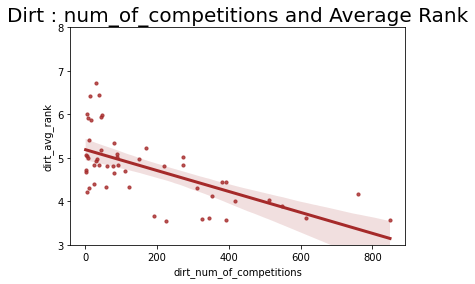

In [27]:
# sns.set_palette(sns.color_palette(dirt_colors))
get_regplot(dirt_app_rank, 'dirt_num_of_competitions', 'dirt_avg_rank', color = 'brown')
get_pearsonr(dirt_app_rank['dirt_num_of_competitions'], dirt_app_rank['dirt_avg_rank'])
plt.title("Dirt : num_of_competitions and Average Rank", fontsize = 20)

corrcoef : -0.5625490140785173, p-value : 0.000105486902442249


Text(0.5, 1.0, 'Turf : num_of_competitions and Average Rank')

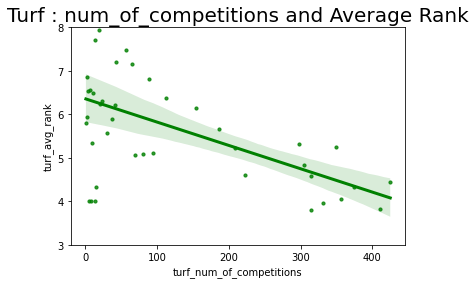

In [28]:
turf_palette
get_regplot(turf_app_rank, 'turf_num_of_competitions', 'turf_avg_rank', color = 'green')
get_pearsonr(turf_app_rank['turf_num_of_competitions'], turf_app_rank['turf_avg_rank'])
plt.title("Turf : num_of_competitions and Average Rank", fontsize = 20)

### View the stadium
- [link](https://www.kaggle.com/code/iamleonie/big-data-derby-step-by-step-analysis#Missing-Data) 
- I didn't think I could draw the stadium by looking at the longitude and latitude data. I'll just look at the idea and implement it myself

In [29]:
track = start_df['track_id'].unique()
total_df = race_df.merge(track_df, on = ['track_id', 'race_date', 'race_number'])

In [30]:
track_lst = race_df['track_id'].unique()
track_lst

array(['AQU', 'BEL', 'SAR'], dtype=object)

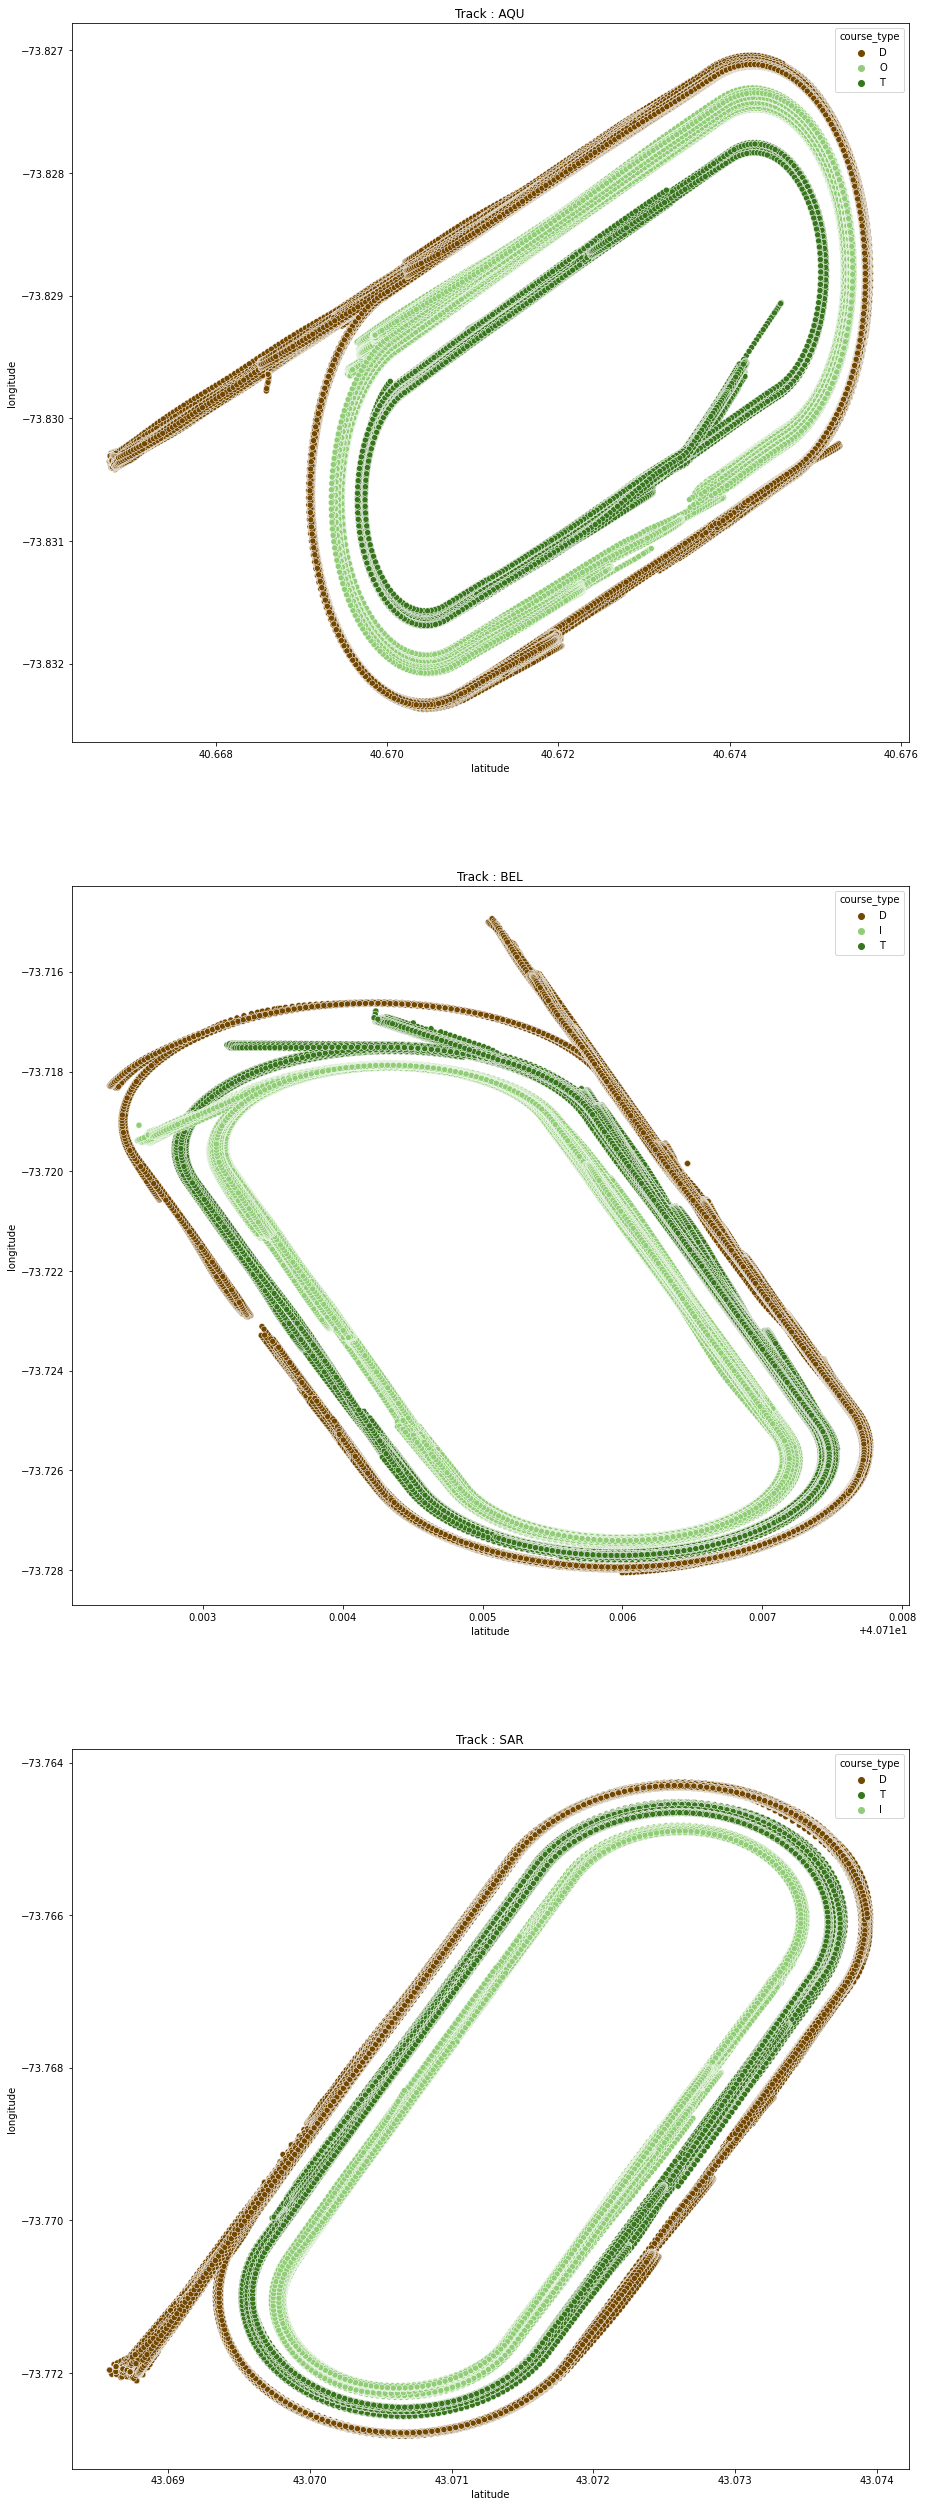

In [31]:
fig, ax = plt.subplots(3, 1, figsize = (15, 45))
track_palette = {'D' : '#744700',
        'T' : '#38761d',
        'I' : '#91cd76',
        'O' : '#91cd76', 
        'M' : '#d9ead3'}

for i, v in enumerate(track_lst):
    temp_df = (
                total_df[(total_df['track_id'] == v) & 
                        (total_df['trakus_index'].isin(list(range(0, 200)))) &
                        (total_df['program_number'].isin(['1', '2', '3']))
                       ]
                        [['course_type', 'latitude', 'longitude']]
                )

    sns.scatterplot(data = temp_df,
                       x = 'latitude',
                       y = 'longitude',
                       hue = 'course_type',
                        ax = ax[i],
                   palette = track_palette)
    
    ax[i].set_title(f'Track : {v}')

# 3. business analysis
- Only analyzed the largest 'Stakes' race

- Race distance ranges from 3630 to 10560 (unit: feet)
- `run_up_distance` : `9 ~ 246`
- 'trakus_index' is well stamped in chronological order.

In [32]:
race_track = track_df.merge(race_df, on = ['race_id', 'track_id', 'race_date', 'race_number'])
# race_track.insert(0, 'race_id', race_track.pop('race_id'))
race_track.drop(['track_id', 'race_date', 'race_number'], axis = 1, inplace = True)
race_track.head(2)

,program_number,trakus_index,latitude,longitude,race_id,distance_id,course_type,run_up_distance,race_type,distance_feet,distance_km,dirt_condition,turf_condition,month,season
0,6,72,40.672902,-73.827607,AQU_2019-01-01_9,600,D,48,CLM,3960,1.206949,GD,NaN,1,winter
1,6,73,40.672946,-73.827587,AQU_2019-01-01_9,600,D,48,CLM,3960,1.206949,GD,NaN,1,winter


In [33]:
stakes = race_track[race_track['race_type'] == 'STK'][:] # 경기 거리는 3630 ~ 10560까지 있다
stk_dirt = stakes[stakes['course_type'] == 'D'][:].drop('turf_condition', axis = 1)

## Selecting and Analyzing a Race
- STK will catch any competition and measure the speed of each driver's Trakus Index
- Speed can be obtained because the interval between Trakus indexes is stated to be 0.25 seconds
- Apply 'haversine' library

In [34]:
# trakus_index로 계산
race_name = 'SAR_2019-08-10_8'
test_race = stk_dirt[stk_dirt['race_id'] == race_name][:]

test_race['next_lat'] = test_race.sort_values(by = ['program_number', 'trakus_index']).groupby('program_number')['latitude'].shift(-1)
test_race['next_lon'] = test_race.sort_values(by = ['program_number', 'trakus_index']).groupby('program_number')['longitude'].shift(-1)

test_race.loc[test_race['next_lat'].notnull(), 'moved'] = (test_race.apply
                                                                           (lambda x : haversine((x['latitude'], x['longitude']), 
                                                                                                 (x['next_lat'], x['next_lon']), 
                                                                                                  unit = 'ft'), 
                                                                            axis = 1)
                                                            )

test_race['velocity_ft/s'] = test_race['moved'] / 0.25 # feet per second
test_race['moved_km'] = test_race['moved'].apply(lambda x : x / 3281)
test_race['velocity_km/h'] = test_race['velocity_ft/s'].apply(lambda x : x / 3281 * 3600)
test_race['elapsed_time'] = (test_race['trakus_index'] - 1) * 0.25
test_race['total_distance'] = test_race.sort_values(by = ['program_number', 'trakus_index']).groupby('program_number')['moved'].cumsum()


In [35]:
test_race.describe()

,trakus_index,latitude,longitude,distance_id,run_up_distance,distance_feet,distance_km,month,next_lat,next_lon,moved,velocity_ft/s,moved_km,velocity_km/h,elapsed_time,total_distance
count,2184.000000,2184.000000,2184.000000,2184.0,2184.0,2184.0,2184.000000,2184.0,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2177.000000,2184.000000,2177.000000
mean,156.500000,43.071951,-73.767849,650.0,72.0,4290.0,1.307528,8.0,43.071960,-73.767838,15.431852,61.727407,0.004703,67.728944,38.875000,2518.035731
std,90.086806,0.001455,0.002347,0.0,0.0,0.0,0.000000,0.0,0.001448,0.002343,2.443056,9.772224,0.000745,10.722343,22.521702,1442.932124
min,1.000000,43.069083,-73.772297,650.0,72.0,4290.0,1.307528,8.0,43.069087,-73.772297,2.380095,9.520380,0.000725,10.446013,0.000000,2.380095
25%,78.750000,43.070772,-73.769925,650.0,72.0,4290.0,1.307528,8.0,43.070786,-73.769908,14.059172,56.236686,0.004285,61.704380,19.437500,1270.121971
50%,156.500000,43.072210,-73.767895,650.0,72.0,4290.0,1.307528,8.0,43.072213,-73.767870,15.869859,63.479434,0.004837,69.651315,38.875000,2596.804720
75%,234.250000,43.073190,-73.765678,650.0,72.0,4290.0,1.307528,8.0,43.073191,-73.765673,17.423792,69.695168,0.005311,76.471382,58.312500,3800.819273
max,312.000000,43.073948,-73.764287,650.0,72.0,4290.0,1.307528,8.0,43.073948,-73.764287,19.008678,76.034712,0.005794,83.427298,77.750000,4901.007789


Text(0.5, 1.0, 'race SAR_2019-08-10_8 : Time and Distance')

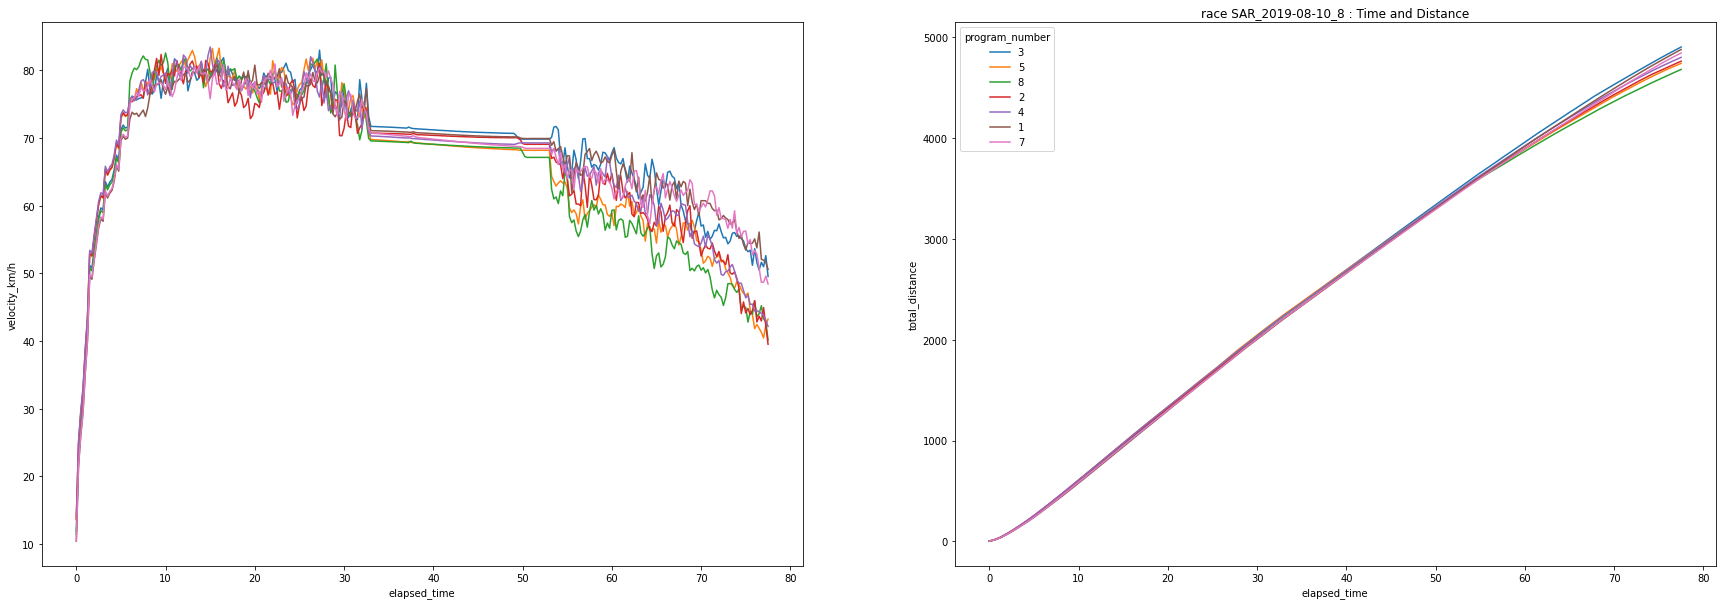

In [36]:
fig, ax = plt.subplots(1, 2, figsize = (30, 10))

sns.lineplot(data = test_race,
            x = 'elapsed_time',
            y = 'velocity_km/h',
            hue = 'program_number',
            ax = ax[0])
plt.title(f"race {'SAR_2019-08-10_8'} : Time and Velocity")

ax[0].legend().set_visible(False)

sns.lineplot(data = test_race,
            x = 'elapsed_time',
            y = 'total_distance',
            hue = 'program_number',
            ax = ax[1])

plt.title(f"race {'SAR_2019-08-10_8'} : Time and Distance")

<AxesSubplot:xlabel='latitude', ylabel='longitude'>

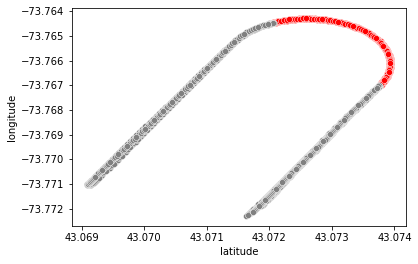

In [37]:
# 30초 ~ 50초 즘에서 나오는 속도가 일정하게 유지되는 구간이 궁금하다

data = test_race[test_race['elapsed_time'].between(31, 50, inclusive = "both")][:]
else_data = test_race[test_race['elapsed_time'].between(31, 50, inclusive = "both") == False][:]

sns.set_palette(turf_palette)
sns.scatterplot(data = data,
               x = 'latitude',
               y = 'longitude',
               color = 'red')

sns.scatterplot(data = else_data,
               x = 'latitude',
               y = 'longitude',
               color = 'grey')


## Get speed from the stakes table
- Apply the above process for individual races to the entire Stake Races

In [38]:
stakes_raw = race_track[race_track['race_type'] == 'STK'][:] 
stakes_raw.drop(['distance_id', 'race_type', 'month', 'season'], axis = 1, inplace = True)
stakes_raw.head(2)

,program_number,trakus_index,latitude,longitude,race_id,course_type,run_up_distance,distance_feet,distance_km,dirt_condition,turf_condition
127497,1,1,43.072430,-73.770416,SAR_2019-08-03_9,D,77,5940,1.810424,FT,NaN
127498,1,2,43.072427,-73.770422,SAR_2019-08-03_9,D,77,5940,1.810424,FT,NaN


In [39]:
stakes_raw['next_lat'] = stakes_raw.sort_values(by = ['race_id', 'program_number', 'trakus_index']).groupby(['race_id', 'program_number'])['latitude'].shift(-1)
stakes_raw['next_lon'] = stakes_raw.sort_values(by = ['race_id', 'program_number', 'trakus_index']).groupby(['race_id', 'program_number'])['longitude'].shift(-1)

stakes_raw.loc[stakes_raw['next_lat'].notnull(), 'moved_ft'] = (stakes_raw.apply
                                                                           (lambda x : haversine((x['latitude'], x['longitude']), (x['next_lat'], x['next_lon']), 
                                                                                                  unit = 'ft'
                                                                                                ),
                                                                            axis = 1)
                                                            )
stakes_raw['velocity_ft'] = stakes_raw['moved_ft'] / 0.25 # feet per second
stakes_raw.loc[stakes_raw['next_lat'].notnull(), 'moved_km'] = (stakes_raw.apply
                                                                           (lambda x : haversine((x['latitude'], x['longitude']), (x['next_lat'], x['next_lon']), 
                                                                                                  unit = 'km'
                                                                                                ),
                                                                            axis = 1)
                                                            )
stakes_raw['velocity_km/h'] = stakes_raw['moved_km'].apply(lambda x : x / 0.25 * 3600)
stakes_raw['elapsed_time'] = (stakes_raw['trakus_index'] - 1) * 0.25
stakes_raw['player_cumulative_moved'] = stakes_raw.sort_values(by = ['race_id', 'program_number', 'trakus_index']).groupby(['race_id', 'program_number'])['moved_km'].cumsum()

stakes_raw

,program_number,trakus_index,latitude,longitude,race_id,course_type,run_up_distance,distance_feet,distance_km,dirt_condition,turf_condition,next_lat,next_lon,moved_ft,velocity_ft,moved_km,velocity_km/h,elapsed_time,player_cumulative_moved
127497,1,1,43.072430,-73.770416,SAR_2019-08-03_9,D,77,5940,1.810424,FT,NaN,43.072427,-73.770422,1.935715,7.742859,0.000590,8.496084,0.00,0.000590
127498,1,2,43.072427,-73.770422,SAR_2019-08-03_9,D,77,5940,1.810424,FT,NaN,43.072420,-73.770438,4.918765,19.675059,0.001499,21.589049,0.25,0.002089
127499,1,3,43.072420,-73.770438,SAR_2019-08-03_9,D,77,5940,1.810424,FT,NaN,43.072413,-73.770453,4.852418,19.409673,0.001479,21.297846,0.50,0.003568
127500,1,4,43.072413,-73.770453,SAR_2019-08-03_9,D,77,5940,1.810424,FT,NaN,43.072405,-73.770472,5.651526,22.606102,0.001723,24.805224,0.75,0.005291
127501,1,5,43.072405,-73.770472,SAR_2019-08-03_9,D,77,5940,1.810424,FT,NaN,43.072393,-73.770497,7.961507,31.846029,0.002427,34.944010,1.00,0.007718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5160524,7,8,43.069156,-73.770873,SAR_2019-08-10_8,D,72,4290,1.307528,FT,NaN,43.069171,-73.770835,11.265120,45.060479,0.003434,49.443962,1.75,0.018244
5160525,7,9,43.069171,-73.770835,SAR_2019-08-10_8,D,72,4290,1.307528,FT,NaN,43.069186,-73.770796,11.879136,47.516544,0.003621,52.138954,2.00,0.021865
5160526,7,10,43.069186,-73.770796,SAR_2019-08-10_8,D,72,4290,1.307528,FT,NaN,43.069202,-73.770754,12.443253,49.773012,0.003793,54.614931,2.25,0.025657
5160527,7,11,43.069202,-73.770754,SAR_2019-08-10_8,D,72,4290,1.307528,FT,NaN,43.069218,-73.770711,12.997285,51.989141,0.003962,57.046644,2.50,0.029619


In [40]:
stakes_raw.describe()

,trakus_index,latitude,longitude,run_up_distance,distance_feet,distance_km,next_lat,next_lon,moved_ft,velocity_ft,moved_km,velocity_km/h,elapsed_time,player_cumulative_moved
count,683284.000000,683284.000000,683284.000000,683284.000000,683284.000000,683284.000000,681485.000000,681485.000000,681485.000000,681485.000000,681485.000000,681485.000000,683284.000000,681485.000000
mean,199.748876,41.359431,-73.770485,75.133353,5553.599250,1.692654,41.359401,-73.770486,15.334716,61.338865,0.004674,67.305910,49.687219,0.936687
std,125.943871,1.065971,0.045018,39.163384,1236.535413,0.376878,1.065954,0.045014,2.127073,8.508292,0.000648,9.335979,31.485968,0.592307
min,1.000000,40.666761,-73.832583,9.000000,3630.000000,1.106370,40.666761,-73.832583,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,96.000000,40.674425,-73.828161,48.000000,4620.000000,1.408107,40.674429,-73.828157,14.789588,59.158352,0.004508,64.913276,23.750000,0.445389
50%,191.000000,40.715017,-73.767401,72.000000,5280.000000,1.609265,40.715018,-73.767393,15.733606,62.934424,0.004796,69.056685,47.500000,0.909818
75%,288.000000,43.069939,-73.724876,86.000000,5940.000000,1.810424,43.069943,-73.724884,16.475938,65.903753,0.005022,72.314870,71.750000,1.361907
max,738.000000,43.073992,-73.714826,246.000000,10560.000000,3.218531,43.073992,-73.714934,250.663232,1002.652927,0.076402,1100.191004,184.250000,3.416150


## Clean up outlier data
- The maximum instantaneous speed taken by a horse is said to be 88 km/h.
- [Related Information](http://www.speedofanimals.com/animals/horse)
- Any value larger than $89.584 km/h$ is treated as an outlier, excluding races with outliers
    - The latitude and longitude data represented up to the sixth decimal place have an error of $0.11 m = 0.00011 km$.
    - And the error speed can have is $0.00011 \times 4 \times 3600$ = $1.584 km/h$. (location is taken every 0.25 seconds)
    - I don't know if the calculation is correct. Welcome criticism.

#### 참고 : 위도, 경도 데이터의 소수점 갯수와 그에 따른 오차
- [관련 링크](https://gis.stackexchange.com/questions/8650/measuring-accuracy-of-latitude-and-longitude)
- 내가 제대로 이해한 게 맞다면
    - 일반적으로 위도`latitude` 1도는 111111m를 덮는다고 알려져 있다. $\frac{10^7}{90}$
    - 경도`longitude` 또한 위도와 비슷하거나 작다. 작아지는 이유는 극으로 갈수록 폭이 좁아지기 때문임
    - 따라서 소수점 6째자리까지 표현된 위도, 경도 데이터가 갖는 오차는 $0.11m = 0.00011km$ 정도이다.
    - 그리고 속도가 가질 수 있는 오차는 $0.00011 \times 4 \times 3600$ = $1.584km/h$이다. (위치는 0.25초마다 찍힘)
    - 계산이 맞나 모르겠음. 비판 환영합니다..
- 따라서 $89.584km/h$보다 큰 값은 모두 이상치 취급하고, 이상치가 들어간 레이스는 제외하겠음

In [41]:
# outliers = stakes[stakes['velocity_km/h'] >= 89.584][:] 
outliers = stakes_raw[stakes_raw['velocity_km/h'] >= 89.584][:] 

outliers.shape # (218, 24)
outliers_races = outliers['race_id'].unique() # 64개의 레이스에 이상치 데이터가 있음 / Stakes 전체 253개

In [42]:
stakes = stakes_raw.drop(stakes_raw[stakes_raw['race_id'].isin(outliers_races)].index)
stakes['race_id'].nunique() # 189

189

### Dirt vs Turf

### Summary
1. The average speed of `Turf` was higher than that of `Dirt` ($67.97 km/h$ vs $66.30 km/h$)
    - Other variables need to be investigated further. The streets of Gyeongju, the weight of the horse.
2. In the case of stadium condition (`dirt_condition` and `turf_condition`), the average speed decreases in common as the ground holds moisture
    - Compared to the best and worst conditions, the average speed reduction of `Turf` was higher ($6.7%), 'Dirt': $3.2%)
3. There was little difference according to Inner Turf, Turf, and Outer Turf.
    - I think it would be okay to tie it with 'Turf' as long as the nature of the track itself is laid down.

1. Average speed depending on track condition: There seems to be no difference

Text(0, 0.5, 'average speed')

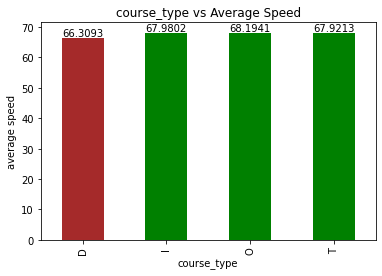

In [43]:
ax = stakes.groupby('course_type')['velocity_km/h'].mean().plot(kind = 'bar', color = ['brown'] + ['green'] * 3)
ax.bar_label(ax.containers[0])
plt.title("course_type vs Average Speed")
plt.ylabel('average speed')

2. Average speed depending on track and track conditions

Text(0.5, 1.0, 'Dirt : Track Condition and Average Speed')

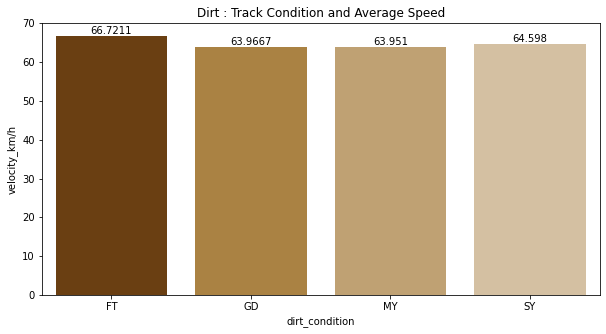

In [44]:
# 1. Dirt
dirt = stakes[stakes['course_type'] == 'D'].groupby('dirt_condition')['velocity_km/h'].mean().to_frame().reset_index()

plt.figure(figsize = (10, 5))
ax = sns.barplot(data = dirt,
           x = 'dirt_condition',
           y = 'velocity_km/h',
           palette = dirt_palette)
ax.bar_label(ax.containers[0])
plt.title("Dirt : Track Condition and Average Speed")

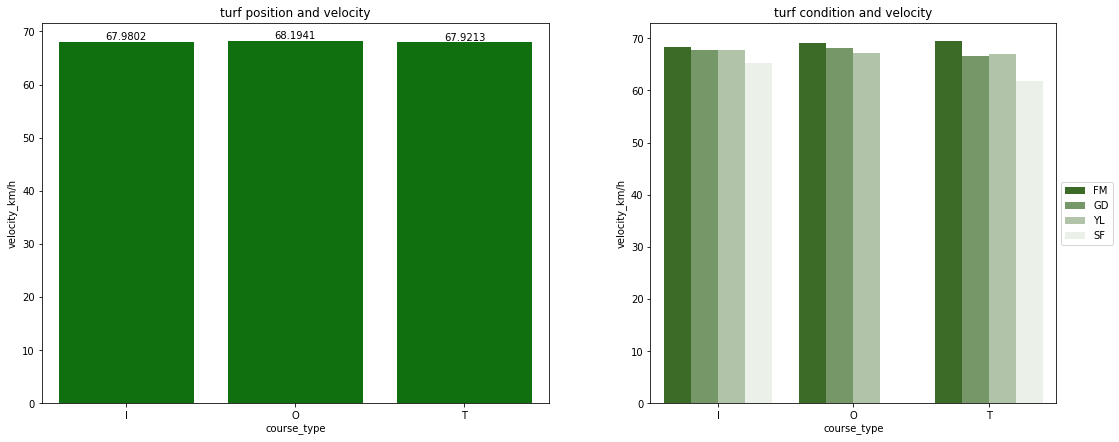

In [45]:
# 2. turf
turf = stakes[stakes['course_type'].isin(['T', 'I', 'O'])].groupby(['course_type', 'turf_condition'])['velocity_km/h'].mean().to_frame().reset_index()
tio = stakes[stakes['course_type'].isin(['T', 'I', 'O'])].groupby(['course_type'])['velocity_km/h'].mean().to_frame().reset_index()
fig, ax = plt.subplots(1, 2, figsize = (20, 7))

sns.barplot(data = tio,
           x = 'course_type',
           y = 'velocity_km/h',
           color = 'green',
           ax = ax[0])
ax[0].set_title('turf position and velocity')
ax[0].bar_label(ax[0].containers[0])


sns.barplot(data = turf,
           x = 'course_type',
           y = 'velocity_km/h',
           hue = 'turf_condition',
           palette = turf_palette,
           ax = ax[1])
ax[1].set_title('turf condition and velocity')

box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[1].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

In [46]:
turf = stakes[stakes['course_type'].isin(['T', 'I', 'O'])][:]
turf.loc[turf['course_type'].isin(['I', 'O']), 'course_type'] = 'T'
turf = turf.groupby(['course_type', 'turf_condition'])['velocity_km/h'].mean().to_frame().reset_index()

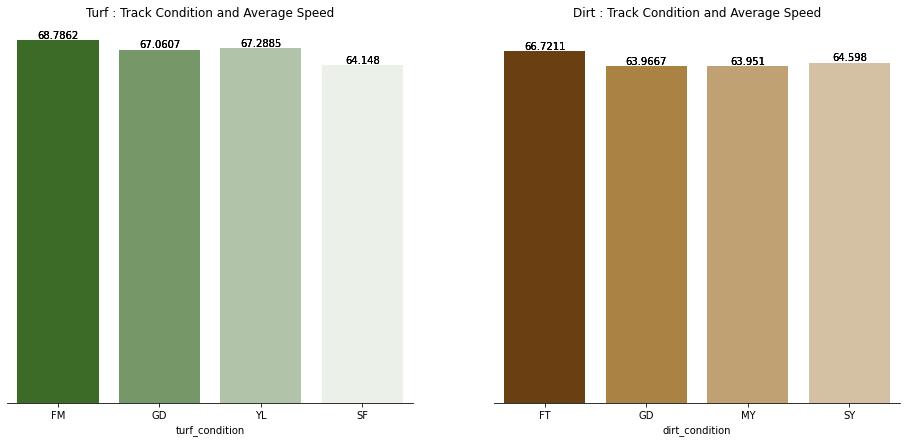

In [47]:
# 시각화는 Dirt와 동시에 보자
fig, ax = plt.subplots(1, 2, figsize = (16, 7), sharey = True)

sns.barplot(data = turf, 
            x = 'turf_condition', 
            y = 'velocity_km/h', 
            ax = ax[0])
ax[0].set_title("Turf : Track Condition and Average Speed")


sns.barplot(data = dirt,
           x = 'dirt_condition',
           y = 'velocity_km/h',
           palette = dirt_palette,
           ax = ax[1])
ax[1].set_title("Dirt : Track Condition and Average Speed")

for i in range(2):
    for j in ['left', 'top', 'right']:
        ax[i].bar_label(ax[i].containers[0])
        ax[i].spines[j].set_visible(False)
        ax[i].get_yaxis().set_visible(False)

Text(0.5, 1.0, 'Course Type and Average Speed')

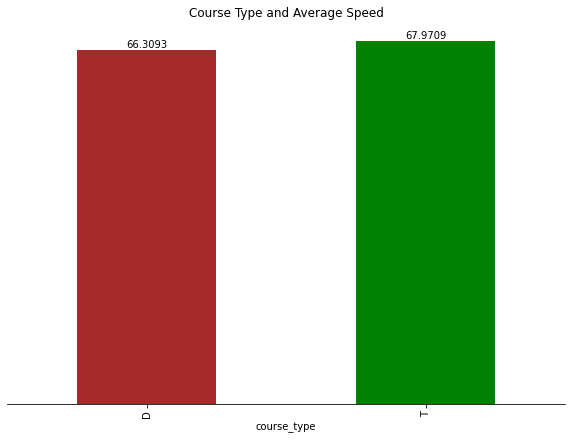

In [48]:
stakes.loc[stakes['course_type'].isin(['I', 'O']), 'course_type'] = 'T'
plt.figure(figsize = (10, 7))
stakes.groupby('course_type')['velocity_km/h'].mean().plot(kind = 'bar', color = ['brown', 'green'])
plt.gca().bar_label(plt.gca().containers[0])
for j in ['left', 'top', 'right']:
    plt.gca().spines[j].set_visible(False)

plt.yticks(ticks = [])

plt.title("Course Type and Average Speed")


In [49]:
stakes = stakes[['race_id', 'program_number', 'trakus_index', 'latitude', 'longitude', 'next_lat', 'next_lon',
                'course_type', 'dirt_condition', 'turf_condition', 'run_up_distance', 'moved_km', 'velocity_km/h', 'elapsed_time']]
# stakes['track_id'] = stakes['race_id'].apply(lambda x : x[0:3])
stakes = stakes.merge(start_df, on = ['race_id', 'program_number'])
stakes.insert(1, 'track_id', stakes.pop('track_id'))
stakes.loc[stakes['course_type'].isin(['I', 'O']), 'course_type'] = 'T'

### Condition 2 Weight and Average Speed

#### Summary
- Contrary to the conventional wisdom that the heavier the weight, the lower the average speed, **did not show a distinct tendency.**
- Rather - On the contrary, **The above once again shows that you can run faster on the Turf**
- The average speed according to the average weight of each competition also does not have a clear trend

Text(0.5, 1.0, 'weight histogram')

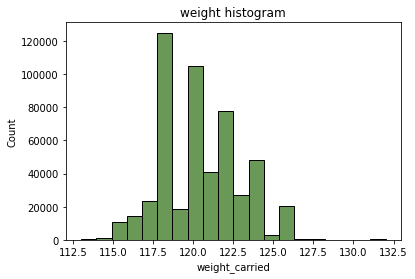

In [50]:
sns.histplot(data = stakes,
            x = 'weight_carried',
#              kde = True,
            bins = 20)
plt.title("weight histogram")

Text(0, 0.5, 'average speed')

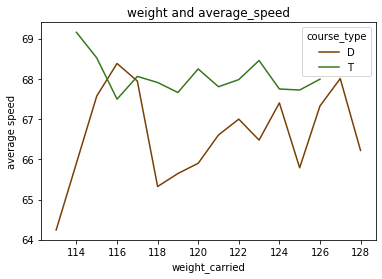

In [51]:
temp_df = stakes[['race_id', 'program_number', 'course_type', 'dirt_condition', 'turf_condition', 'weight_carried', 'velocity_km/h', 'elapsed_time', 'position_at_finish']]
temp_df = temp_df[temp_df['weight_carried'].between(110, 130, inclusive = 'both')][:]
# print(temp_df.head(2))
temp_df = temp_df.groupby(['weight_carried', 'course_type'])['velocity_km/h'].agg(['mean', 'count']).dropna().reset_index()

sns.lineplot(data = temp_df,
           x = 'weight_carried',
           y = 'mean',
           hue = 'course_type',
          palette = [dirt_palette[0], turf_palette[0]])

plt.title('weight and average_speed')
plt.ylabel("average speed")

## 

### Average weight and average speed

In [52]:
temp_df = stakes[['race_id', 'program_number', 'course_type', 'velocity_km/h', 'weight_carried']]
temp_df.head(2)

,race_id,program_number,course_type,velocity_km/h,weight_carried
0,AQU_2019-02-17_7,5,D,58.907865,120
1,AQU_2019-02-17_7,5,D,59.773105,120


In [53]:
temp_df.loc[:, 'race_avg_weight'] = temp_df.groupby('race_id')['weight_carried'].transform('mean')
temp_df.loc[:, 'race_avg_speed'] = temp_df.groupby('race_id')['velocity_km/h'].transform('mean')
temp_df.loc[:, 'player_avg_speed'] = temp_df.groupby(['race_id', 'program_number'])['velocity_km/h'].transform('mean')
temp_df.head(2)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,race_id,program_number,course_type,velocity_km/h,weight_carried,race_avg_weight,race_avg_speed,player_avg_speed
0,AQU_2019-02-17_7,5,D,58.907865,120,120.666667,66.383882,65.396976
1,AQU_2019-02-17_7,5,D,59.773105,120,120.666667,66.383882,65.396976


In [54]:
temp_df2 = temp_df.groupby(['course_type', 'race_avg_weight'])['race_avg_speed'].mean()
temp_df2

course_type  race_avg_weight
D            117.285714         66.439945
             117.400000         68.750402
             117.428571         68.356895
             117.571429         69.142408
             117.818182         66.922983
                                  ...    
T            123.142857         71.625509
             123.800000         70.070210
             124.000000         68.756617
             124.181818         65.691376
             126.000000         67.415240
Name: race_avg_speed, Length: 132, dtype: float64

Text(0.5, 1.0, 'Turf : Average Weight and Average Speed')

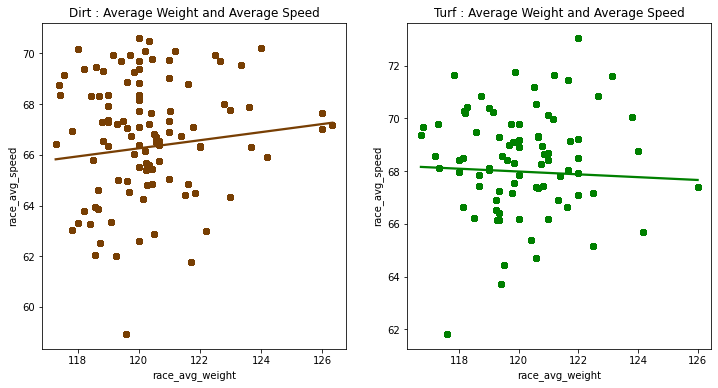

In [55]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.regplot(data = temp_df[temp_df['course_type'] == 'D'][:], 
             x = 'race_avg_weight', 
             y = 'race_avg_speed', 
             color = dirt_palette[0],
#              ci = True,
             ax = ax[0]
            )
ax[0].set_title('Dirt : Average Weight and Average Speed')


sns.regplot(data = temp_df[temp_df['course_type'] == 'T'][:], 
             x = 'race_avg_weight', 
             y = 'race_avg_speed', 
             color = 'green',
#             ci = True,
             ax = ax[1]
            )
ax[1].set_title('Turf : Average Weight and Average Speed')


### Condition 3: Average speed according to total mileage

#### Summary
1. Naturally, **The longer the distance, the lower the average speed**
2. **The mileage of each race** is not continuous and **discrete** (now I know this)
    - Of the 1991 data excluding the hurdle race in `race_df`, there are 16 unique values of the mileage
    - If you come to 'stakes', the race has a total of 189 data and 14 unique values for the mileage
3. It seems difficult to explain the reduction depending on the track condition except for the best management condition

In [56]:
temp_df = stakes[['race_id', 'course_type', 'dirt_condition', 'turf_condition', 'program_number', 'moved_km', 'velocity_km/h', 'elapsed_time']]
temp_df = temp_df.merge(race_df[['race_id', 'distance_feet']], on = 'race_id')
temp_df['race_distance_km'] = temp_df['distance_feet'].apply(lambda x : x / 3281)
temp_df = temp_df.drop('distance_feet', axis = 1)
temp_df['race_avg_speed_km/h'] = temp_df.groupby(['race_id'])['velocity_km/h'].transform('mean')

Text(0.5, 1.0, 'Dirt : Race Distance and Average Speed')

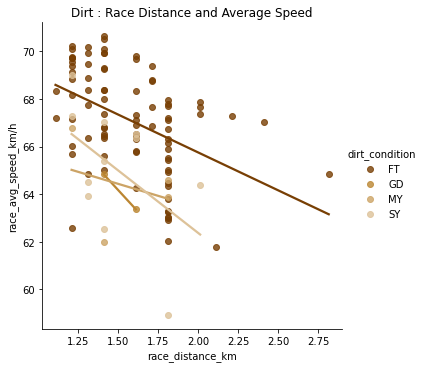

In [57]:
temp_df = temp_df[['race_id', 'course_type', 'dirt_condition', 'turf_condition', 'race_distance_km', 'race_avg_speed_km/h']].drop_duplicates()

# fig, ax = plt.subplots(1, 2, figsize = (16, 9), sharex = True, sharey = True)

sns.lmplot(data = temp_df[temp_df['course_type'] == 'D'][:], 
            x = 'race_distance_km', 
            y = 'race_avg_speed_km/h', 
            hue = 'dirt_condition',
            palette = dirt_palette,
#            ax = ax[0],
           ci = False
          )
plt.title("Dirt : Race Distance and Average Speed")
# ax[0].set_title("Dirt : Race Distance and Average Speed")

Text(0.5, 1.0, 'Turf : Race Distance and Average Speed')

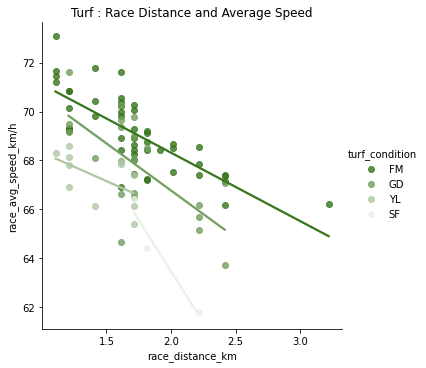

In [58]:
sns.lmplot(data = temp_df[temp_df['course_type'] == 'T'][:], 
            x = 'race_distance_km', 
            y = 'race_avg_speed_km/h', 
            hue = 'turf_condition',
            palette = turf_palette,
#            ax = ax[1],
           ci = False
          )
# ax[1].set_title("Turf : Race Distance and Average Speed")
plt.title("Turf : Race Distance and Average Speed")

<AxesSubplot:xlabel='race_distance_km', ylabel='Count'>

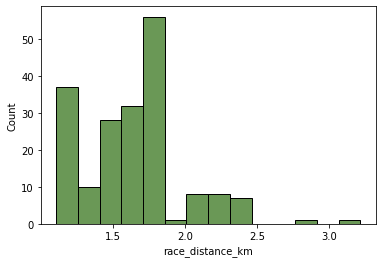

In [59]:
sns.histplot(temp_df['race_distance_km'], bins = 14)

### Condition 4: Average speed and average distance depending on the condition of the stadium and the ground

#### 1. In terms of the stadium alone, the average speed is **BEL > SAR > AQU**.
1. In `BEL` and `SAR`, relatively many `Turf` games were held & there were many games that maintained the bottom condition well
2. On the other hand, `AQU` had a higher proportion of `Dirt` games than the other two stadiums, and there were many games that did not maintain the best floor condition

#### 2. Meanwhile, there is a question about `AQU - DIRT - FT`
- Measured lower average speed despite shorter mileage compared to the other two stadiums
- Not even unusual cases with a small number of data. 


In [60]:
race_df['race_distance_km'] = race_df['distance_feet'].apply(lambda x : x / 3281)
stakes = stakes.merge(race_df[['race_id', 'distance_feet', 'race_distance_km']], on = 'race_id')
stadium_df = stakes[['race_id', 'track_id', 'course_type', 'dirt_condition', 'turf_condition', 'race_distance_km', 'velocity_km/h']]


In [61]:
# 중복 제거
no_dup_stdium = stadium_df[['race_id', 'track_id', 'course_type', 'dirt_condition', 'turf_condition', 'race_distance_km']].drop_duplicates()

dirt_stdium = no_dup_stdium[no_dup_stdium['course_type'] == 'D'][:]
turf_stdium = no_dup_stdium[no_dup_stdium['course_type'] == 'T'][:]

<AxesSubplot:xlabel='track_id', ylabel='race_distance_km'>

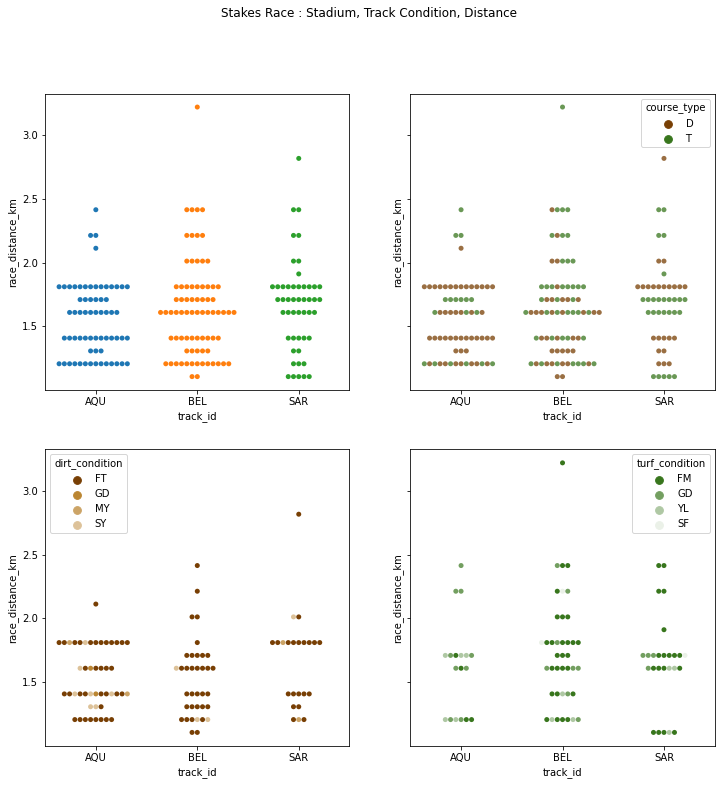

In [62]:
id_dist = dict(x = 'track_id', y = 'race_distance_km')
''
fig, ax = plt.subplots(2, 2, figsize = (12, 12), sharey = True)

fig.suptitle("Stakes Race : Stadium, Track Condition, Distance")

sns.swarmplot(data = no_dup_stdium, **id_dist, ax = ax[0][0], palette = 'tab10')
sns.swarmplot(data = no_dup_stdium, **id_dist, hue = 'course_type', palette = dt_palette, alpha = 0.75, ax = ax[0][1])
# ax[0][1].ylabel.set_visible(False)
sns.swarmplot(data = dirt_stdium, **id_dist, hue = 'dirt_condition', palette = dirt_palette, ax = ax[1][0])
sns.swarmplot(data = turf_stdium, **id_dist, hue = 'turf_condition', palette = turf_palette, ax = ax[1][1])
# ax[1][1].ylabel.set_visible(False)


In [63]:
stadium_df = stakes[['race_id', 'track_id', 'course_type', 'dirt_condition', 'turf_condition', 'velocity_km/h', 'moved_km']]
stadium_df = stadium_df.merge(race_df[['race_id','race_distance_km']], on = 'race_id')
stadium_df

,race_id,track_id,course_type,dirt_condition,turf_condition,velocity_km/h,moved_km,race_distance_km
0,AQU_2019-02-17_7,AQU,D,FT,NaN,58.907865,0.004091,1.609265
1,AQU_2019-02-17_7,AQU,D,FT,NaN,59.773105,0.004151,1.609265
2,AQU_2019-02-17_7,AQU,D,FT,NaN,58.893449,0.004090,1.609265
3,AQU_2019-02-17_7,AQU,D,FT,NaN,57.004668,0.003959,1.609265
4,AQU_2019-02-17_7,AQU,D,FT,NaN,57.783201,0.004013,1.609265
...,...,...,...,...,...,...,...,...
518107,SAR_2019-08-10_8,SAR,D,FT,NaN,49.443962,0.003434,1.307528
518108,SAR_2019-08-10_8,SAR,D,FT,NaN,52.138954,0.003621,1.307528
518109,SAR_2019-08-10_8,SAR,D,FT,NaN,54.614931,0.003793,1.307528
518110,SAR_2019-08-10_8,SAR,D,FT,NaN,57.046644,0.003962,1.307528


In [64]:
dist_speed = stadium_df.groupby(['track_id'])[['velocity_km/h', 'race_distance_km']].mean().reset_index().dropna()
track_dist_speed = stadium_df.groupby(['track_id', 'course_type'])[['velocity_km/h', 'race_distance_km']].mean().reset_index().dropna()
dirt_cond_dist_speed = stadium_df[stadium_df['course_type'] == 'D'].groupby(['track_id', 'dirt_condition'])[['velocity_km/h', 'race_distance_km']].mean().reset_index().dropna()
turf_cond_dist_speed = stadium_df[stadium_df['course_type'] == 'T'].groupby(['track_id', 'turf_condition'])[['velocity_km/h', 'race_distance_km']].mean().reset_index().dropna()

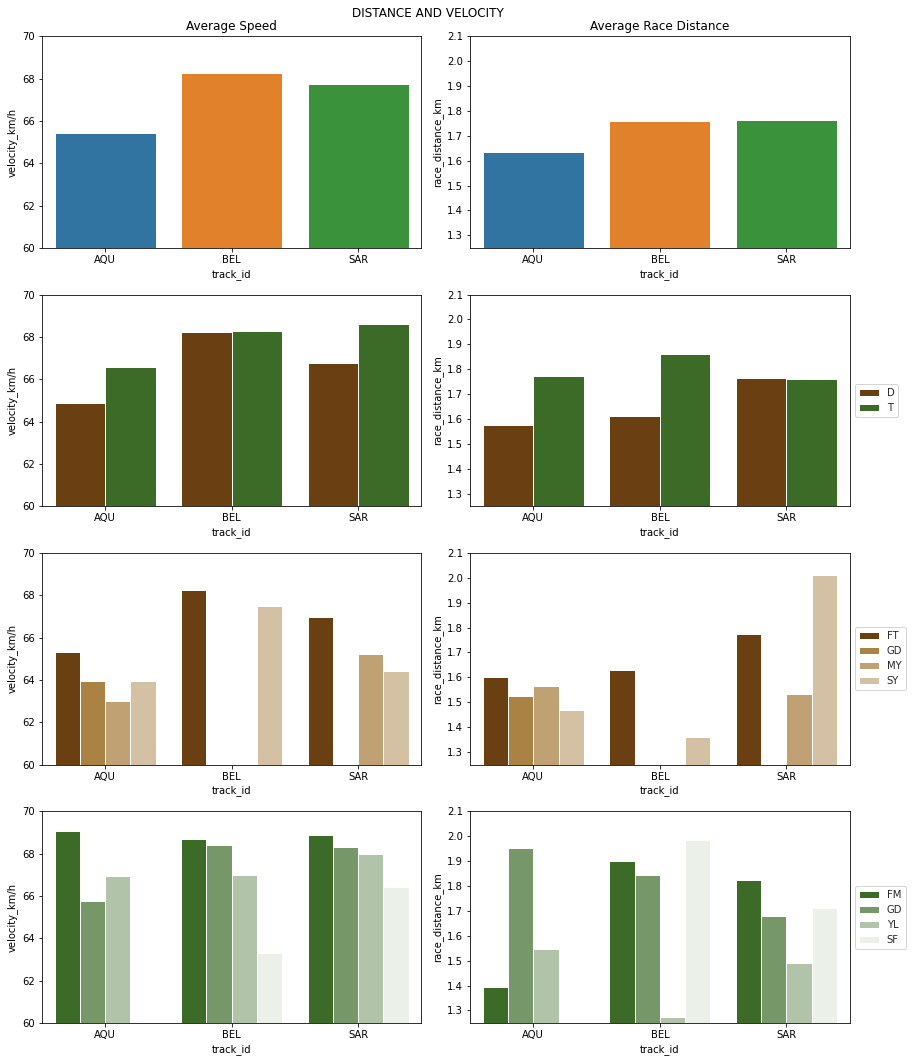

In [65]:

fig, ax = plt.subplots(4, 2, figsize = (12, 15))
fig.suptitle("DISTANCE AND VELOCITY")
sns.set_style("ticks",{'axes.grid' : True})
sns.barplot(
                 data = dist_speed, 
                 x = 'track_id', 
                 y = 'velocity_km/h',
                 palette = 'tab10',
                 ax = ax[0][0]
)

ax[0][0].set_ylim([65, 70])
ax[0][0].set_title("Average Speed")

sns.barplot(
                 data = dist_speed, 
                 x = 'track_id', 
                 y = 'race_distance_km',
                 palette = 'tab10',
                 ax = ax[0][1]
)

ax[0][1].set_ylim([1.6, 1.8])
ax[0][1].set_title("Average Race Distance")

sns.barplot(
                 data = track_dist_speed, 
                 x = 'track_id', 
                 y = 'velocity_km/h',
                 hue = 'course_type',
                 palette = dt_palette,
                 ax = ax[1][0]
)
sns.barplot(
                 data = track_dist_speed, 
                 x = 'track_id', 
                 y = 'race_distance_km',
                 hue = 'course_type',
                 palette = dt_palette,
                 ax = ax[1][1]
)
ax[1][0].legend().set_visible(False)
box = ax[1][1].get_position()
ax[1][1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[1][1].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

sns.barplot(
                 data = dirt_cond_dist_speed, 
                 x = 'track_id', 
                 y = 'velocity_km/h',
                 hue = 'dirt_condition',
                 palette = dirt_palette,
                 ax = ax[2][0]
)
sns.barplot(
                 data = dirt_cond_dist_speed, 
                 x = 'track_id', 
                 y = 'race_distance_km',
                 hue = 'dirt_condition',
                 palette = dirt_palette,
                 ax = ax[2][1]
)

ax[2][0].legend().set_visible(False)
box = ax[2][1].get_position()
ax[2][1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[2][1].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

sns.barplot(
                 data = turf_cond_dist_speed, 
                 x = 'track_id', 
                 y = 'velocity_km/h',
                 hue = 'turf_condition',
                 palette = turf_palette,
                 ax = ax[3][0]
)
sns.barplot(
                 data = turf_cond_dist_speed, 
                 x = 'track_id', 
                 y = 'race_distance_km',
                 hue = 'turf_condition',
                 palette = turf_palette,
                 ax = ax[3][1]
)

ax[3][0].legend().set_visible(False)
box = ax[3][1].get_position()
ax[3][1].set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax[3][1].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

plt.setp([ax[i][0] for i in range(4)], ylim = (60, 70))
plt.setp([ax[i][1] for i in range(4)], ylim = (1.25, 2.1))

# 값 표시
# for i in range(4):
#     for j in range(2):
#         for k in range(len(ax[i][j].containers)):
#             ax[i][j].bar_label(ax[i][j].containers[k])

fig.tight_layout()

In [66]:
race_counts = stadium_df[['race_id', 'track_id', 'course_type', 'dirt_condition', 'turf_condition', 'race_distance_km']].drop_duplicates()
race_counts.head(3)

,race_id,track_id,course_type,dirt_condition,turf_condition,race_distance_km
0,AQU_2019-02-17_7,AQU,D,FT,NaN,1.609265
2280,AQU_2019-04-06_9,AQU,D,FT,NaN,1.408107
4569,BEL_2019-10-19_6,BEL,D,FT,NaN,1.307528


In [67]:
dirt= pd.pivot_table(race_counts[race_counts['course_type'] == 'D'],
              index = 'track_id',
              columns = ['course_type', 'dirt_condition'],
              values = 'race_id',
              aggfunc = 'count')

dirt.columns = ['D_FT', 'D_GD', 'D_MY', 'D_SY']
dirt= dirt.reset_index()

turf= pd.pivot_table(race_counts[race_counts['course_type'] == 'T'],
              index = 'track_id',
              columns = ['course_type', 'turf_condition'],
              values = 'race_id',
              aggfunc = 'count')
turf.columns = ['T_FM', 'T_GD', 'T_YL', 'T_SF']
turf= turf.reset_index()

merged = dirt.merge(turf, on = 'track_id')

merged

,track_id,D_FT,D_GD,D_MY,D_SY,T_FM,T_GD,T_YL,T_SF
0,AQU,35,2,2,7,4,9,5,0
1,BEL,33,0,0,3,27,8,3,2
2,SAR,20,0,2,1,18,4,3,1


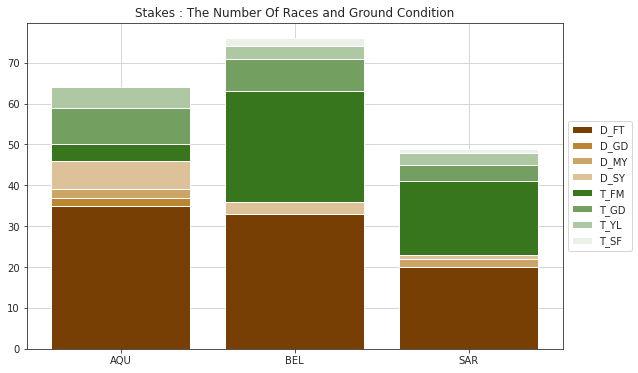

In [68]:
merged_palette = dirt_palette + turf_palette

fig, ax = plt.subplots(figsize = (12, 6))

btm = np.zeros(len(merged))

for i, val in enumerate(merged.columns[1:]):
    ax.bar(merged['track_id'], merged[val], bottom = btm, label = val, color = merged_palette[i])
    btm += np.array(merged[val])
    
plt.title("Stakes : The Number Of Races and Ground Condition")

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))

# ax.bar_label(ax.containers[0])
# ax.bar_label(ax.containers[4])

### Condition 5. `run_up_distance`

#### Summary
- **'trakus_index' is not exactly the beginning to end of the game**
- When they left the gate ~ Recorded even after the competition ends
- Therefore, the average speed obtained above is not an accurate value: an integral calculation is likely to be necessary to obtain a more accurate value.

- [Description 1](https://paulickreport.com/horseplayers-category/thoroughbred-idea-foundation-run-up-made-final-time-misleading-in-jessamine/)
- [Description 2](https://www.youtube.com/watch?v=9xx-0LvEAk8)
    - If you look at `2:00`, there are two intuitive examples
- The total distance of the race is from gate to destination.
- However, measuring time in the horse race is not when you leave the gate, but at a certain point, which is a certain from the gate.
- The distance from the gate to the point where the time starts is called `run_up_distance`.

**Is 'trakus_index' measured from the time you started leaving 'run_up_distance'? Or is it being measured from the point of departure from the gate?**
- How can I get this?
    - Find the cumulative distance
    - Is this value greater than `race_distance`? Or is it smaller than `race_distance` and larger than `race_distance` - `run_up_distance`?
    - I think we can compare these two

In [69]:
stakes['run_up_distance_km'] = stakes['run_up_distance'].apply(lambda x : x / 3281)
stakes['without_run_up_km'] = stakes['race_distance_km'] - stakes['run_up_distance_km']
stakes = stakes.sort_values(by = 'trakus_index', ascending = True)
stakes['total_moved_km'] = (stakes.groupby(['race_id', 'program_number'])['moved_km']
                                  .cumsum()
                           )
test = stakes.sample(6)['race_id'].values

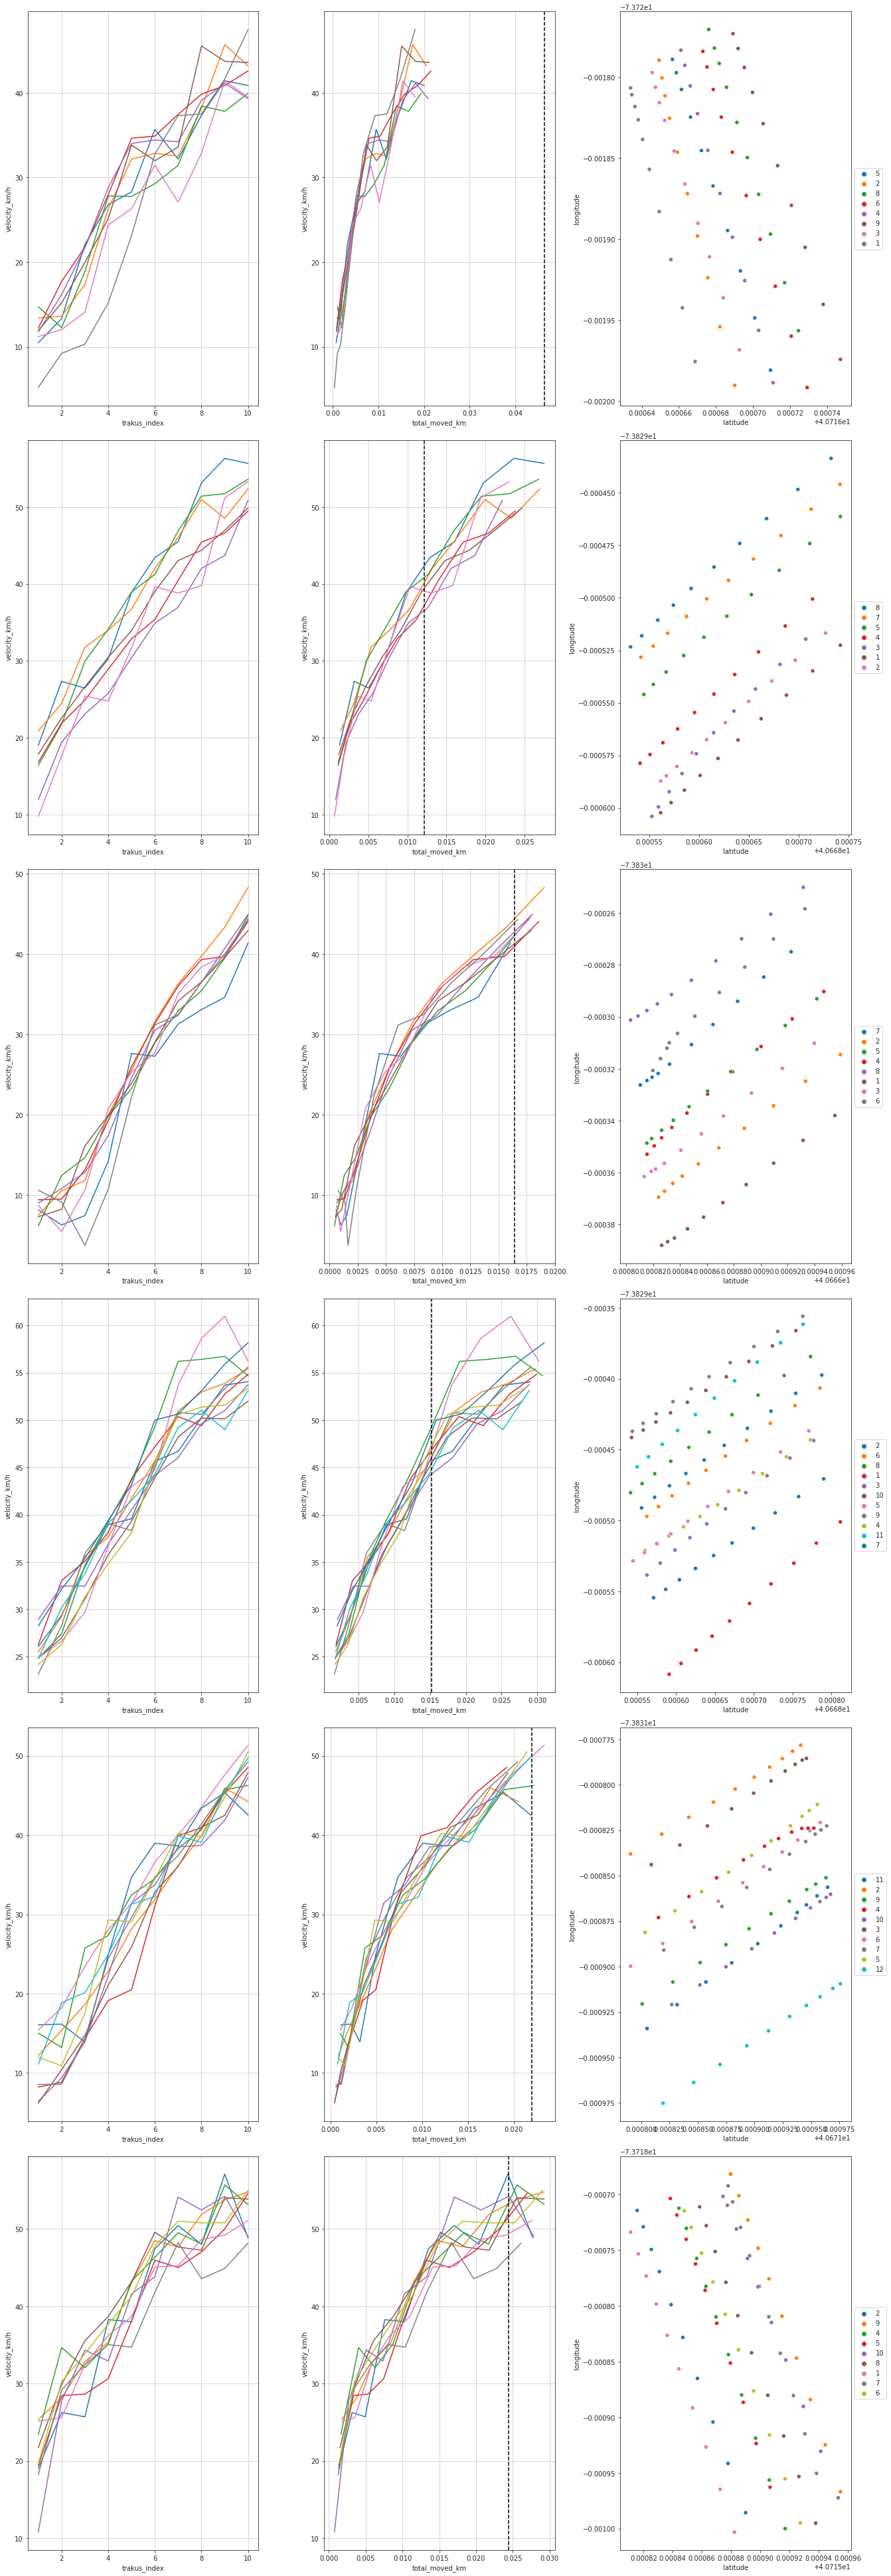

In [70]:
fig, ax = plt.subplots(len(test), 3, figsize = (18, 54))
trakus_idx_min = 0
trakus_idx_max = 10


for i in range(len(test)):
    sample = stakes[stakes['race_id'] == test[i]][:]
    sns.lineplot(
                data = sample[sample['trakus_index'].between(trakus_idx_min, trakus_idx_max, inclusive = 'both')],
                 x = 'trakus_index', 
                 y = 'velocity_km/h', 
                 hue = 'program_number', 
                 ax = ax[i][0],
                palette = 'tab10'
    )  
    ax[i][0].legend().set_visible(False)
#     ax[i][0].axvline(x = sample.loc[sample.index[0], 'run_up_distance_km'], color = 'black', linestyle = '--')
#     ax[i][0].text(10.1,0,'blah',rotation=90)
    sns.lineplot(
                    data = sample[sample['trakus_index'].between(trakus_idx_min, trakus_idx_max, inclusive = 'both')],
                     x = 'total_moved_km', 
                     y = 'velocity_km/h', 
                     hue = 'program_number', 
                     ax = ax[i][1],
                    palette = 'tab10'
        )
    ax[i][1].axvline(x = sample.loc[sample.index[0], 'run_up_distance_km'], color = 'black', linestyle = '--')
    ax[i][1].legend().set_visible(False)

    sns.scatterplot(data = sample[sample['trakus_index'].between(trakus_idx_min, trakus_idx_max, inclusive = 'both')],
                    x = 'latitude' ,
                    y = 'longitude', 
                    hue = 'program_number', 
                    ax = ax[i][2],
                    palette = 'tab10'
                   )
    box = ax[i][2].get_position()
    ax[i][2].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax[i][2].legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    ax[i][2].grid(False)
    
fig.tight_layout()
# fig.suptitle(f'Observe {trakus_idx_max * 0.25}sec after the start of the match')


### Looks like coordinates are starting to take place as soon as you leave the gate
- If the speed starts to be taken after `run_up_distance`, the measurement will start at some speed.
- Each row represents a sample competition, and the second graph is a plot showing the cumulative travel distance and the speed at that time. The black dotted line corresponds to `run_up_distance`.

- On the other hand, compare the total distance taken in the above-mentioned latitude/longitude coordinates with the average value of the actual distance for each horse

Text(0.5, 1.0, 'Known Distance vs Actual Moved')

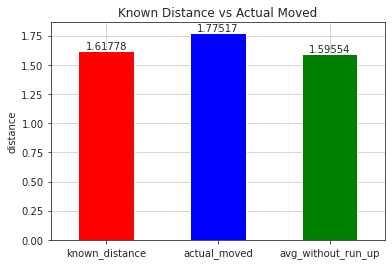

In [71]:
comp = stakes[['race_id', 'trakus_index', 'program_number', 'race_distance_km', 'run_up_distance_km', 'without_run_up_km', 'total_moved_km']]
comp2 = (comp.groupby('race_id')['trakus_index'].max()-1).to_frame().reset_index()
merged = comp.merge(comp2, on = ['race_id', 'trakus_index'])

merged[['avg_moved_km', 'avg_without_run_up']] = merged.groupby('race_id')[['total_moved_km', 'without_run_up_km']].transform('mean')
merged = merged[['race_id', 'race_distance_km', 'avg_moved_km', 'avg_without_run_up']].drop_duplicates()
(merged[['race_distance_km', 'avg_moved_km', 'avg_without_run_up']].rename(columns = {'race_distance_km' : 'known_distance',
                                                                                     'avg_moved_km' : 'actual_moved',
                                                                                     'avg_withpout_run_up' : 'actual_moved_without_run_up'})
                                                                     .mean()
                                                                     .plot(kind = 'bar', color = ['red', 'blue', 'green'])
)
plt.xticks(rotation = 0)
plt.ylabel('distance')
plt.gca().bar_label(plt.gca().containers[0])
plt.title("Known Distance vs Actual Moved")

- `trakus_index` does not accurately measure the start - end of a competition.
- This is because the distance of movement (red bar) specified in the game is about 160 meters different from the actual distance of movement (blue bar).
- On the other hand, on average, the value excluding `run_up_distance` has only an error of about 20m with the travel distance specified in the game.

### So to put it together with what we talked about above
1. **The time when the actual race is measured and the time when 'trakus_index' is measured are different.** The former is included in the latter.
2. If only the recorded game is to be measured, the accumulated moving distance and average speed obtained above for the reason of 1.
- However, it is not necessary to improve each instantaneous speed measured by 'trakus_index'.
    - The time when the first word passes by `run_up_distance`
    - Time each horse passes through the end position (`race_distance`)
- If you only get the above two, you'll be able to get the average horse speed in each game
- I thought of a heuristic approach first, but **There is an error with the actual ranking due to an interval of 0.25 seconds**
- So if you want to use the data to **exact point**, you'd be right to **use the integration**

-----------------------------------

#### Heuristic approach: failure

#### summary
- Use `trakus_index` to record the start and finish of the competition (**0.25 seconds of error**)
- Even if it was heuristic, there was an assumption that the average speed of the recorded interval would be ranked in the order of high speed
    - It wasn't like that in reality
- The conclusion that the race needs to save continuity even if it is not continuous data, and integration will be necessary for this

- Find the average speed for each race
- It looks like the best way to find integration, but I'll go with heuristics
    - How many seconds after the start of the game, I thought there would be data on whether it passed `run_up_distance` so I approached like this.
    - I don't know if there will be a calculation cost issue.
- Heuristics: The data taken at trackus: n is measured by the distance and speed traveled to n -> n+1
    - Therefore, you can select the smallest value among the values of `trakus_index` greater than `run_up_distance`

In [72]:
# 특정 레이스부터 보겠음
sample_race = stakes['race_id'].sample(1).values[0]
sample_run = stakes[stakes['race_id'] == sample_race][:]

In [73]:
sample_run.columns

Index(['race_id', 'track_id', 'program_number', 'trakus_index', 'latitude',
       'longitude', 'next_lat', 'next_lon', 'course_type', 'dirt_condition',
       'turf_condition', 'run_up_distance', 'moved_km', 'velocity_km/h',
       'elapsed_time', 'race_date', 'race_number', 'weight_carried', 'jockey',
       'odds', 'position_at_finish', 'distance_feet', 'race_distance_km',
       'run_up_distance_km', 'without_run_up_km', 'total_moved_km'],
      dtype='object')

In [74]:
sample_run = sample_run[['program_number', 'trakus_index', 'elapsed_time', 'total_moved_km', 'velocity_km/h', 'race_distance_km', 'run_up_distance_km']]
sample_run['elapsed_time'] = sample_run['elapsed_time'] + 0.25
sample_run

,program_number,trakus_index,elapsed_time,total_moved_km,velocity_km/h,race_distance_km,run_up_distance_km
81158,5,1,0.25,0.000729,10.492441,3.218531,0.046327
80420,2,1,0.25,0.000932,13.423972,3.218531,0.046327
85586,8,1,0.25,0.001024,14.747439,3.218531,0.046327
82634,6,1,0.25,0.000849,12.221804,3.218531,0.046327
81896,4,1,0.25,0.000818,11.777817,3.218531,0.046327
...,...,...,...,...,...,...,...
82742,6,738,184.50,NaN,NaN,3.218531,0.046327
81997,4,738,184.50,NaN,NaN,3.218531,0.046327
84211,1,738,184.50,NaN,NaN,3.218531,0.046327
84949,3,738,184.50,NaN,NaN,3.218531,0.046327


In [75]:
find_start_time = (sample_run[sample_run['total_moved_km'] >= sample_run['run_up_distance_km']]
                                                                         .sort_values(by = 'trakus_index'))
sample_run['start_time'] = find_start_time.loc[find_start_time.index[0], 'elapsed_time']

#### It can be said that the game started between 0.25 seconds before `start_time` and `start_time`
- I set it up like this to make sure that the game area is clear
- The end of the competition is also set to the point at which the cumulative travel distance exceeds `race_distance_km`

In [76]:
find_end_time = (sample_run[sample_run['total_moved_km'] >= sample_run['race_distance_km']].sort_values(by = 'trakus_index')
                                                                                                           .groupby('program_number')['elapsed_time']
                                                                                                            .min())
sample_run = sample_run.merge(find_end_time.to_frame().rename(columns = {'elapsed_time' : 'finish_time'}), on = 'program_number')
sample_run['avg_speed'] = (sample_run['race_distance_km'] - sample_run['run_up_distance_km']) / (sample_run['finish_time'] - sample_run['start_time']) * 3600
result = sample_run[['program_number', 'avg_speed']].drop_duplicates()

In [77]:
result = result.merge(start_df[start_df['race_id'] == sample_race][['program_number', 'position_at_finish']], on = 'program_number')

In [78]:
result.sort_values(by = 'avg_speed', ascending = False)

,program_number,avg_speed,position_at_finish
6,3,67.374236,1
4,4,67.176076,5
0,5,67.077433,3
3,6,67.077433,2
2,8,66.979079,6
5,9,66.979079,4
1,2,66.588530,8
7,1,66.588530,7


#### Conclusion: The method of measuring the average speed after heuristic selection of the game time is wrong
- Therefore, it is important to select the exact time of the game, but I think it will be possible using integration (although this is not a completely accurate value)
- However, I can't proceed with this process because I don't have time and I want to try something else

----------------------------------


#### AQU_DIRT_FT
- About 'DIRT_FT': Why is the average speed slow even though the average race length is short?
#### Summary
- I tried 2 criteria, but neither of them got a satisfactory explanation.
1. The **average weight** of `AQU` was not particularly heavier.
2. The tendency of the average speed to decrease with **number of participants** is weak. However, races with a large number of participants are often long.
3. If you fix both the floor condition and length and look at the trend according to the number of participants, you can see a tendency to decrease the speed from 5 to 8 participants, but it cannot be said that always.

In [79]:
dirt_ft = stakes[(stakes['course_type'] == 'D') & 
                (stakes['dirt_condition'] == 'FT')][:]
dirt_ft['elapsed_time'] += 0.25
dirt_ft = dirt_ft.drop(['latitude', 'longitude', 'next_lat', 'next_lon', 'course_type', 'dirt_condition', 'turf_condition',
             'race_date'], axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


(65.0, 70.0)

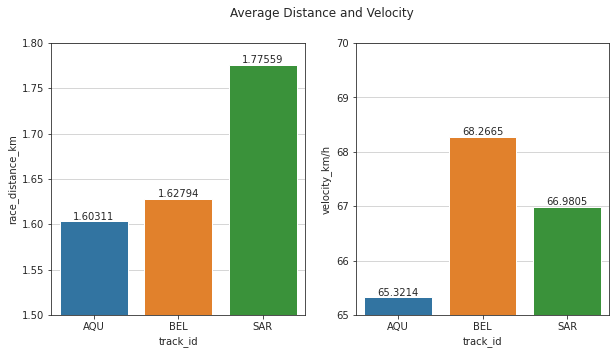

In [80]:
# 1. 위에서도 봤지만 다시 한번 평균 거리와 평균 속도
temp = dirt_ft.groupby('track_id')['velocity_km/h', 'race_distance_km'].mean().reset_index()

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

fig.suptitle("Average Distance and Velocity")

sns.barplot(data = temp, x = 'track_id', y = 'race_distance_km', palette = 'tab10', ax = ax[0])
ax[0].bar_label(ax[0].containers[0])
ax[0].set_ylim(1.5, 1.8)

sns.barplot(data = temp, x = 'track_id', y = 'velocity_km/h', palette = 'tab10', ax = ax[1])
ax[1].bar_label(ax[1].containers[0])
ax[1].set_ylim(65, 70)

In [81]:
# AQU = dirt_ft[dirt_ft['track_id'] == 'AQU'][:]
# BEL = dirt_ft[dirt_ft['track_id'] == 'BEL'][:]
# SAR = dirt_ft[dirt_ft['track_id'] == 'SAR'][:]

#### Approach 1. Average Weight
- Although no clear trend was found between weight and speed above, it can be inferred that there may be a relationship.
- Conclusion) No. There is little difference in average weight.

In [82]:
tab10 = sns.color_palette('tab10')

(array([0, 1, 2]), [Text(0, 0, 'AQU'), Text(1, 0, 'BEL'), Text(2, 0, 'SAR')])

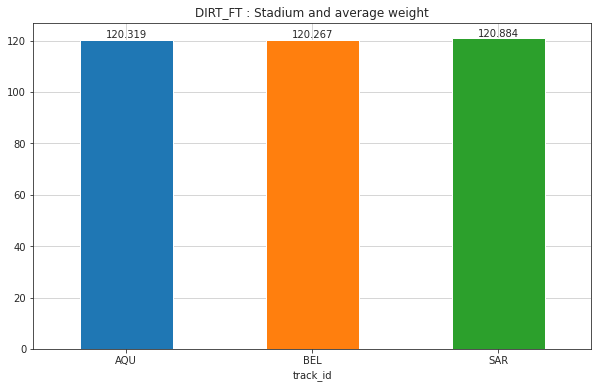

In [83]:
plt.figure(figsize = (10, 6))

ax = (dirt_ft[['race_id', 'track_id', 'program_number', 'weight_carried']]
        .drop_duplicates()
         .groupby('track_id')['weight_carried']
         .mean()
         .plot(kind = 'bar', color = tab10[:3]))

ax.bar_label(ax.containers[0])
ax.set_title('DIRT_FT : Stadium and average weight')
plt.xticks(rotation = 0)

#### Approach 2. Number of competitors
- Wouldn't it be slower on average because the more people participate in each game, the more distractions they get?

[Text(0, 0, '7.08571'), Text(0, 0, '6.36364'), Text(0, 0, '6.9')]

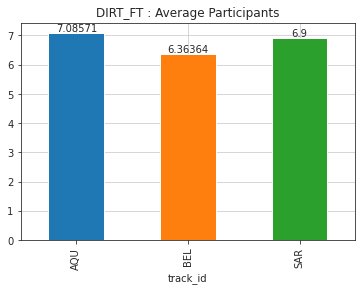

In [84]:
ax = (dirt_ft[['race_id', 'track_id', 'program_number']]
        .drop_duplicates()
         .groupby(['track_id', 'race_id'])['program_number']
         .count()
         .groupby('track_id')
         .mean()
          .plot(kind = 'bar', color = tab10[:3])
     )
ax.set_title('DIRT_FT : Average Participants')
ax.bar_label(ax.containers[0])

#### Is a decrease in the number of people and average speed a common phenomenon?
- There is a tendency like that, but I don't think it is enough to make a difference of about 3km/h.
- In addition, **Tends to have a large number of participants in long-distance races**

(1.25, 2.1)

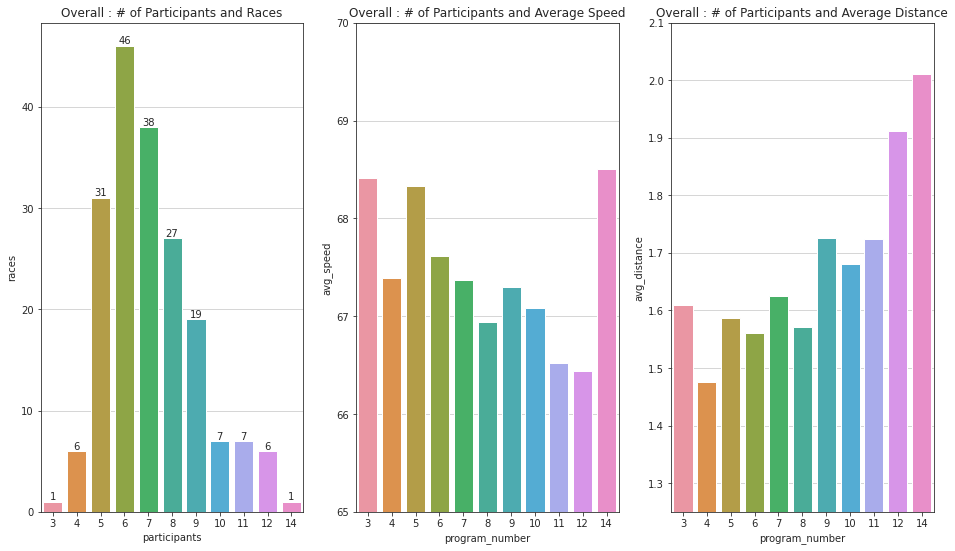

In [85]:
temp2 = (stakes[['race_id', 'program_number']].drop_duplicates()
                                                    .groupby('race_id')['program_number']
                                                    .count()
                                                    .to_frame()
                                                    .reset_index()
                                                    .rename(columns = {'program_numbers' : 'members'})
                )
members_races = temp2.groupby('program_number')['race_id'].count().to_frame().reset_index().rename(columns = {'program_number' : 'participants','race_id' : 'races'})

race_members = (stakes[['race_id', 'program_number']].drop_duplicates()
                                                    .groupby('race_id')['program_number']
                                                    .count()
                                                    .to_frame()
                                                    .reset_index()
                                                    .rename(columns = {'program_numbers' : 'members'})
                )
race_speed = (stakes[['race_id', 'velocity_km/h']].groupby(['race_id'])['velocity_km/h']
                                                      .mean()
                                                      .to_frame()
                                                      .reset_index()
                                                      .rename(columns = {'velocity_km/h' : 'avg_speed'})
)

race_members_speed = race_members.merge(race_speed, on = 'race_id')
race_members_speed = race_members_speed.groupby('program_number')['avg_speed'].mean().to_frame().reset_index()


race_dist = (stakes[['race_id', 'race_distance_km']].groupby(['race_id'])['race_distance_km']
                                                      .mean()
                                                      .to_frame()
                                                      .reset_index()
                                                      .rename(columns = {'race_distance_km' : 'avg_distance'})
)
race_members_dist = race_members.merge(race_dist, on = 'race_id')
race_members_dist = race_members_dist.groupby('program_number')['avg_distance'].mean().to_frame().reset_index()


# 시각화
fig, ax = plt.subplots(1, 3, figsize = (16, 9))

sns.barplot(data = members_races,
           x = 'participants',
           y = 'races',
           ax = ax[0])

ax[0].set_title('Overall : # of Participants and Races')
ax[0].bar_label(ax[0].containers[0])


sns.barplot(data = race_members_speed, x = 'program_number', y = 'avg_speed', ax = ax[1])
ax[1].set_title('Overall : # of Participants and Average Speed')
ax[1].set_ylim([65, 70])

sns.barplot(data = race_members_dist, x = 'program_number', y = 'avg_distance', ax = ax[2])
ax[2].set_title('Overall : # of Participants and Average Distance')
ax[2].set_ylim([1.25, 2.1])

In [86]:
temp2 = (dirt_ft[['race_id', 'program_number']].drop_duplicates()
                                                    .groupby('race_id')['program_number']
                                                    .count()
                                                    .to_frame()
                                                    .reset_index()
                                                    .rename(columns = {'program_numbers' : 'members'})
                )
members_races = temp2.groupby('program_number')['race_id'].count().to_frame().reset_index().rename(columns = {'program_number' : 'participants','race_id' : 'races'})

race_members = (dirt_ft[['race_id', 'program_number']].drop_duplicates()
                                                    .groupby('race_id')['program_number']
                                                    .count()
                                                    .to_frame()
                                                    .reset_index()
                                                    .rename(columns = {'program_numbers' : 'members'})
                )
race_speed = (dirt_ft[['race_id', 'velocity_km/h']].groupby(['race_id'])['velocity_km/h']
                                                      .mean()
                                                      .to_frame()
                                                      .reset_index()
                                                      .rename(columns = {'velocity_km/h' : 'avg_speed'})
)

race_members_speed = race_members.merge(race_speed, on = 'race_id')
race_members_speed = race_members_speed.groupby('program_number')['avg_speed'].mean().to_frame().reset_index()

# # 시각화
# fig, ax = plt.subplots(1, 2, figsize = (16, 9))

# sns.barplot(data = members_races,
#            x = 'participants',
#            y = 'races',
#            ax = ax[0],
#            color = dirt_palette[0])


# ax[0].set_title('DIRT_FT : # of Participants and Races')
# ax[0].bar_label(ax[0].containers[0])


# sns.barplot(data = race_members_speed, x = 'program_number', y = 'avg_speed', color = dirt_palette[1], ax = ax[1])
# ax[1].set_title('DIRT_FT : # of Participants and Average Speed')
# ax[1].set_ylim([65, 70])

In [87]:
# 주행거리가 영향을 미치니까 주행거리도 살펴보자 : x축은 레이스 당 참가인원 수, y축은 주행 거리 및 평균 속도
temp = dirt_ft[['race_id', 'program_number', 'race_distance_km']].drop_duplicates()
temp['participants'] = temp.groupby(['race_id'])['program_number'].transform('count')
temp = temp.drop('program_number', axis = 1).drop_duplicates()
temp

,race_id,race_distance_km,participants
387172,BEL_2019-06-08_11,2.413898,10
254693,SAR_2019-08-24_5,1.408107,6
296855,SAR_2019-08-23_10,1.810424,9
500567,BEL_2019-06-06_7,1.106370,7
62024,AQU_2019-12-07_10,1.609265,11
...,...,...,...
49178,BEL_2019-09-22_3,1.307528,5
512333,BEL_2019-10-19_8,1.609265,6
47174,BEL_2019-06-15_9,1.206949,5
182466,BEL_2019-05-11_1,1.307528,5


In [88]:
# 레이스의 평균 속도도 뽑자
temp2 = dirt_ft[['race_id', 'program_number', 'velocity_km/h']]
temp2['race_avg_velocity'] = temp2.groupby('race_id')['velocity_km/h'].transform('mean')
temp2 = temp2.drop(['program_number', 'velocity_km/h'], axis = 1).drop_duplicates() 
temp2.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,race_id,race_avg_velocity
387172,BEL_2019-06-08_11,67.013716
254693,SAR_2019-08-24_5,70.494731
296855,SAR_2019-08-23_10,66.149553
500567,BEL_2019-06-06_7,67.201785
62024,AQU_2019-12-07_10,66.922983


In [89]:
temp3 = temp.merge(temp2, on = 'race_id')
temp3.head(1)

,race_id,race_distance_km,participants,race_avg_velocity
0,BEL_2019-06-08_11,2.413898,10,67.013716


Text(0.5, 1.0, 'DIRT_FT : # of Participants and Average Distance')

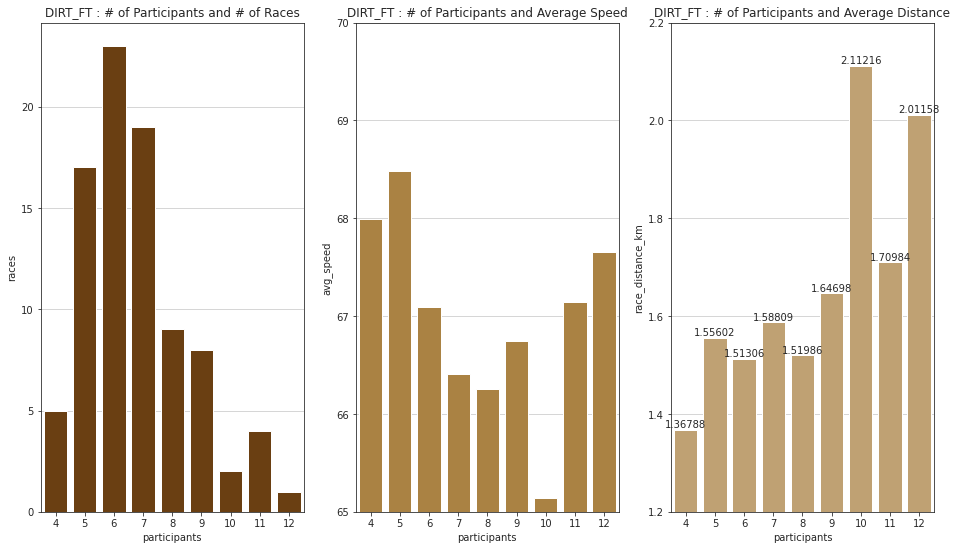

In [90]:
fig, ax = plt.subplots(1, 3, figsize = (16, 9))

sns.barplot(data = members_races,
           x = 'participants',
           y = 'races',
           ax = ax[0],
           color = dirt_palette[0])

ax[0].set_title('DIRT_FT : # of Participants and # of Races')
# ax[0].bar_label(ax[0].containers[0])

sns.barplot(data = race_members_speed.rename(columns = {'program_number' : 'participants'}), x = 'participants', y = 'avg_speed', color = dirt_palette[1], ax = ax[1])
ax[1].set_title('DIRT_FT : # of Participants and Average Speed')
ax[1].set_ylim([65, 70])

sns.barplot(data = temp3, x = 'participants', y = 'race_distance_km', ci = False, ax = ax[2], color = dirt_palette[2])
ax[2].set_ylim([1.2, 2.2])
ax[2].bar_label(ax[2].containers[0])
ax[2].set_title('DIRT_FT : # of Participants and Average Distance')


- It is a graph about the number of games, average speed, and distance.
- When comparing participants 6 and 8 with the most similar average distance (6m difference), it can be seen that the average speed of 8 is low
- It seems necessary to compare values that have the same distance and have different numbers of participants

In [91]:
dist_values = temp3['race_distance_km'].value_counts()
dist_mode_idx = dist_values.index[:5]

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '5'),
  Text(1, 0, '6'),
  Text(2, 0, '7'),
  Text(3, 0, '8'),
  Text(4, 0, '9')])

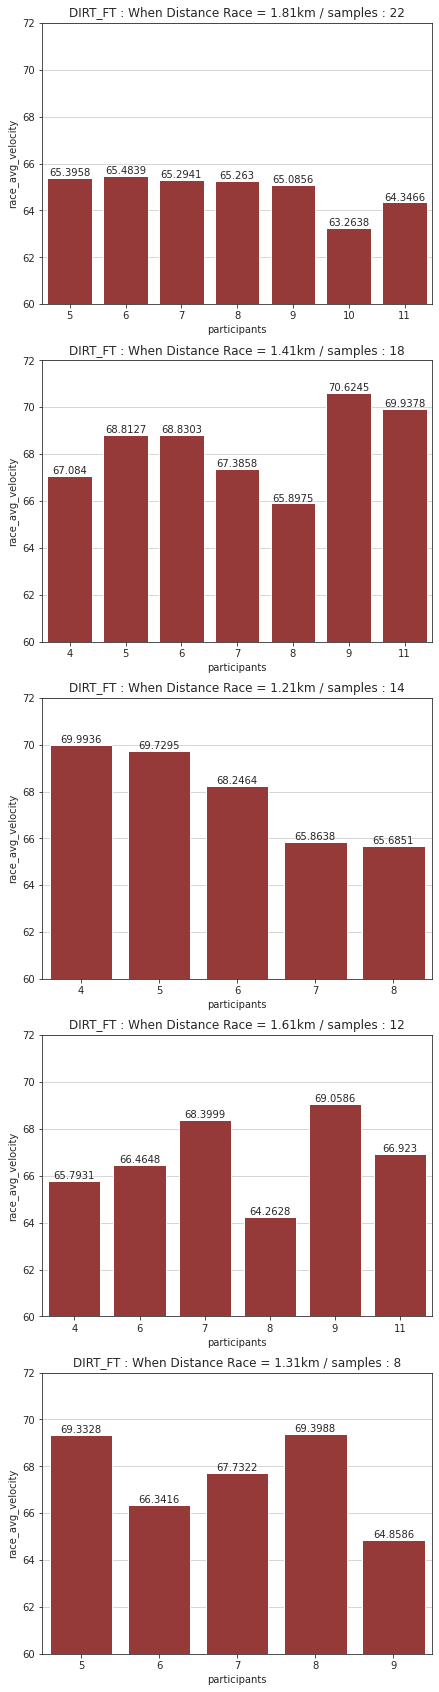

In [92]:
fig, ax = plt.subplots(len(dist_mode_idx), 1, figsize = (7, 30))

for i in range(len(dist_mode_idx)):
    t = (temp3[temp3['race_distance_km'] == dist_mode_idx[i]][:]
                                                             .groupby('participants')['race_avg_velocity']
                                                             .mean()
                                                             .to_frame()
                                                            .reset_index()
        )
    sns.barplot(data = t, x = 'participants', y = 'race_avg_velocity', color = 'brown', ax = ax[i])
    ax[i].set_ylim([60, 72])
    ax[i].bar_label(ax[i].containers[0])
    ax[i].set_title(f"DIRT_FT : When Distance Race = {round(dist_mode_idx[i], 2)}km / samples : {dist_values[dist_mode_idx[i]]}")
plt.xticks(rotation = 0)

- It will be difficult to conclude because each race distance has different patterns.

- That's all I've done.
- If you have any advice, please leave a comment. That'll be really helpful for me. Thank you.